# Importas librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy  as np

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Cargar la base de datos

In [ ]:
df=pd.read_csv('/content/survey_results_public.csv')

In [ ]:
df.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


Se pone como indice el id de respuesta

In [ ]:
df.set_index(['ResponseId'],inplace=True)

# Analisis exploratorio

In [ ]:
Variable_Objetivo = ['AIThreat']

In [ ]:
print(df[Variable_Objetivo[0]].value_counts())
print(f"Empty fields for {Variable_Objetivo[0]}: {df[Variable_Objetivo[0]].isnull().sum()}")

AIThreat
No              30423
I'm not sure     8878
Yes              5388
Name: count, dtype: int64
Empty fields for AIThreat: 20748


In [ ]:
df=df.dropna(subset=[Variable_Objetivo[0]])

In [ ]:
df=df[df[Variable_Objetivo[0]].isin(['No', 'Yes'])]
df[Variable_Objetivo[0]].value_counts()

,count
AIThreat,
No,30423
Yes,5388


In [ ]:
df[Variable_Objetivo[0]] = df[Variable_Objetivo[0]].replace({'No': 0, 'Yes': 1})
df[Variable_Objetivo[0]].value_counts()

/tmp/ipython-input-1373658388.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[Variable_Objetivo[0]] = df[Variable_Objetivo[0]].replace({'No': 0, 'Yes': 1})


,count
AIThreat,
0,30423
1,5388


In [ ]:
missing = []
for col in df.columns:
        missing.append(df[col].isnull().sum() * 100 / len(df))

numerical_missing = pd.DataFrame({'column_name': df.columns,'percent_missing': missing})
numerical_missing.sort_values('percent_missing',ascending=False, inplace=True)
numerical_missing.reset_index(drop=True, inplace=True)

pd.set_option('display.float_format', '{:.4f}'.format)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
 print(numerical_missing)

                        column_name  percent_missing
0        AINextMuch less integrated          97.4226
1             AINextLess integrated          94.7195
2                   EmbeddedAdmired          73.8879
3            EmbeddedWantToWorkWith          72.3660
4                   AINextNo change          71.6568
5        AINextMuch more integrated          70.0176
6            EmbeddedHaveWorkedWith          64.6031
7               ConvertedCompYearly          59.1299
8                       Knowledge_9          51.6741
9                       Knowledge_8          51.4646
10                      Knowledge_7          51.4423
11                      Frequency_3          51.3501
12                      Knowledge_6          51.2943
13                      Knowledge_5          51.2664
14                 ProfessionalTech          51.2245
15                      Knowledge_2          50.9955
16                      Knowledge_4          50.9927
17                      Knowledge_3          5

In [ ]:
variables_seleccionadas = numerical_missing[numerical_missing['percent_missing'] <=70.0]['column_name'].tolist()
df_final=df[variables_seleccionadas]

In [ ]:
caracteristicas_categoricas_T = df_final.select_dtypes(include=['object']).columns.tolist()
caracteristicas_numericas_T = df_final.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"""Caracteristicas Categoricas:
{caracteristicas_categoricas_T}
-------------------------------------------------------------------------------------------------------------------------------

Caracteristicas numericas:
{caracteristicas_numericas_T}""")

Caracteristicas Categoricas:
['EmbeddedHaveWorkedWith', 'Knowledge_9', 'Knowledge_8', 'Knowledge_7', 'Frequency_3', 'Knowledge_6', 'Knowledge_5', 'ProfessionalTech', 'Knowledge_2', 'Knowledge_4', 'Knowledge_3', 'Frustration', 'Frequency_2', 'Frequency_1', 'ProfessionalCloud', 'Knowledge_1', 'ProfessionalQuestion', 'TimeAnswering', 'MiscTechAdmired', 'Industry', 'TimeSearching', 'ICorPM', 'AINextMore integrated', 'AIToolNot interested in Using', 'PlatformAdmired', 'MiscTechWantToWorkWith', 'WebframeAdmired', 'PlatformWantToWorkWith', 'OfficeStackAsyncAdmired', 'DatabaseAdmired', 'OfficeStackAsyncWantToWorkWith', 'TechDoc', 'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith', 'AIToolInterested in Using', 'DatabaseWantToWorkWith', 'AISearchDevAdmired', 'ToolsTechAdmired', 'PlatformHaveWorkedWith', 'BuildvsBuy', 'AISearchDevWantToWorkWith', 'TechEndorse', 'OfficeStackSyncAdmired', 'SOPartFreq', 'BuyNewTool', 'TBranch', 'ToolsTechWantToWorkWith', 'WebframeHaveWorkedWith', 'AIToolCurrently Us

## Campos Numericos

In [ ]:
for variable in caracteristicas_numericas_T:
    descripcion = df_final[variable].describe().to_frame().T

    mediana = df_final[variable].median()
    iqr = df_final[variable].quantile(0.75) - df_final[variable].quantile(0.25)

    descripcion['median'] = mediana
    descripcion['IQR'] = iqr

    display(descripcion)

,count,mean,std,min,25%,50%,75%,max,median,IQR
ConvertedCompYearly,14636.0000,87200.6377,222971.4364,1.0000,30914.0000,64444.0000,107937.0000,16256603.0000,64444.0000,77023.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSat,18324.0000,6.9992,2.0816,0.0000,6.0000,7.0000,8.0000,10.0000,7.0000,2.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_1,18424.0000,20.0804,27.0245,0.0000,0.0000,10.0000,25.0000,100.0000,10.0000,25.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_4,18461.0000,7.7797,18.9484,0.0000,0.0000,0.0000,5.0000,100.0000,0.0000,5.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_5,18470.0000,10.9169,22.8715,0.0000,0.0000,0.0000,10.0000,100.0000,0.0000,10.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_11,18497.0000,10.7859,22.7616,0.0000,0.0000,0.0000,10.0000,100.0000,0.0000,10.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_7,18499.0000,24.2064,27.8805,0.0000,0.0000,15.0000,30.0000,100.0000,15.0000,30.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_6,18499.0000,24.8330,27.6957,0.0000,0.0000,20.0000,30.0000,100.0000,20.0000,30.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_10,18499.0000,11.9236,23.9388,0.0000,0.0000,0.0000,10.0000,100.0000,0.0000,10.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_9,18502.0000,17.0047,25.8923,0.0000,0.0000,7.0000,20.0000,100.0000,7.0000,20.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
JobSatPoints_8,18508.0000,21.1369,26.9305,0.0000,0.0000,10.0000,30.0000,100.0000,10.0000,30.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
WorkExp,18637.0000,11.2021,8.9939,0.0000,4.0000,9.0000,15.0000,50.0000,9.0000,11.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
CompTotal,20947.0000,47739533107413949672882383582174712940297521772...,69093800812636971249153993358407008065563710619...,0.0000,60000.0000,114000.0000,295000.0000,99999999999999999209038626283633850822756121694...,114000.0000,235000.0000


,count,mean,std,min,25%,50%,75%,max,median,IQR
AIThreat,35811.0000,0.1505,0.3575,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


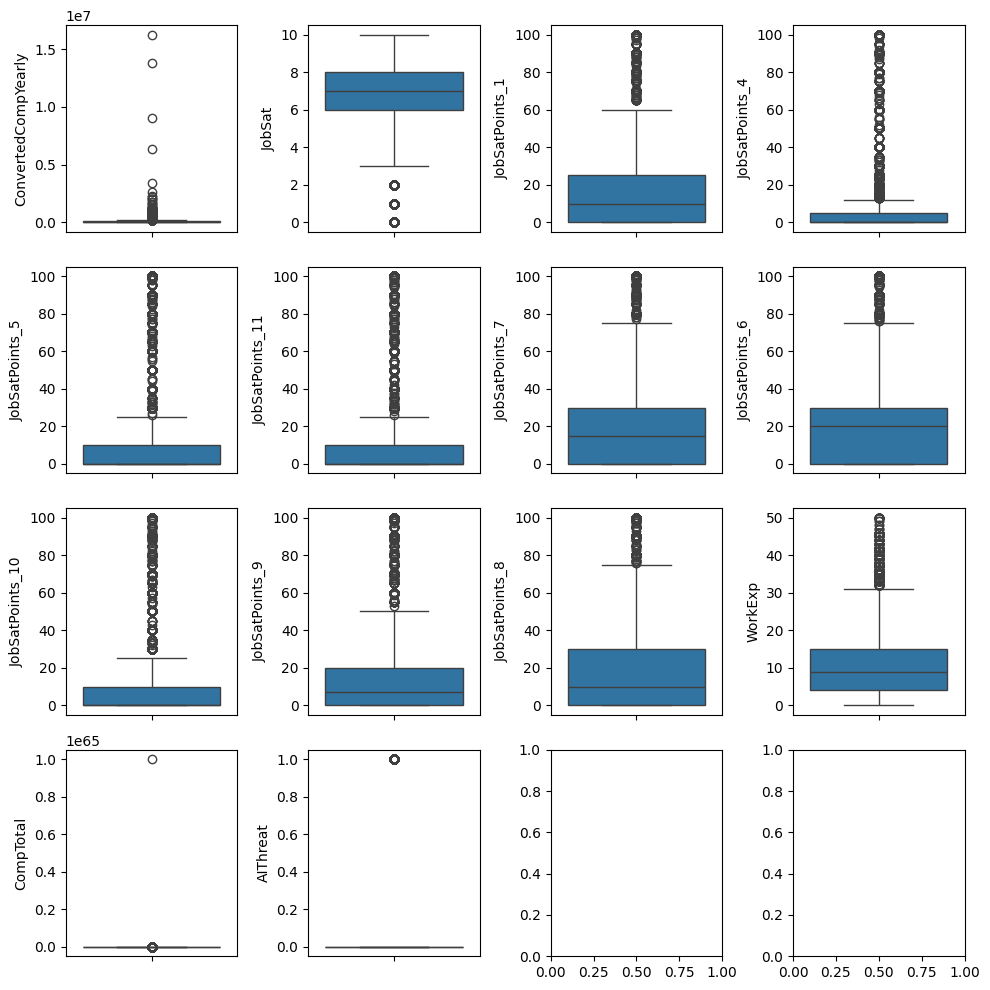

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(10,10 ))
for variable, subplot in zip(caracteristicas_numericas_T, ax.flatten()):
    sns.boxplot(y=df_final[variable],orient="v", ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

fig.tight_layout()

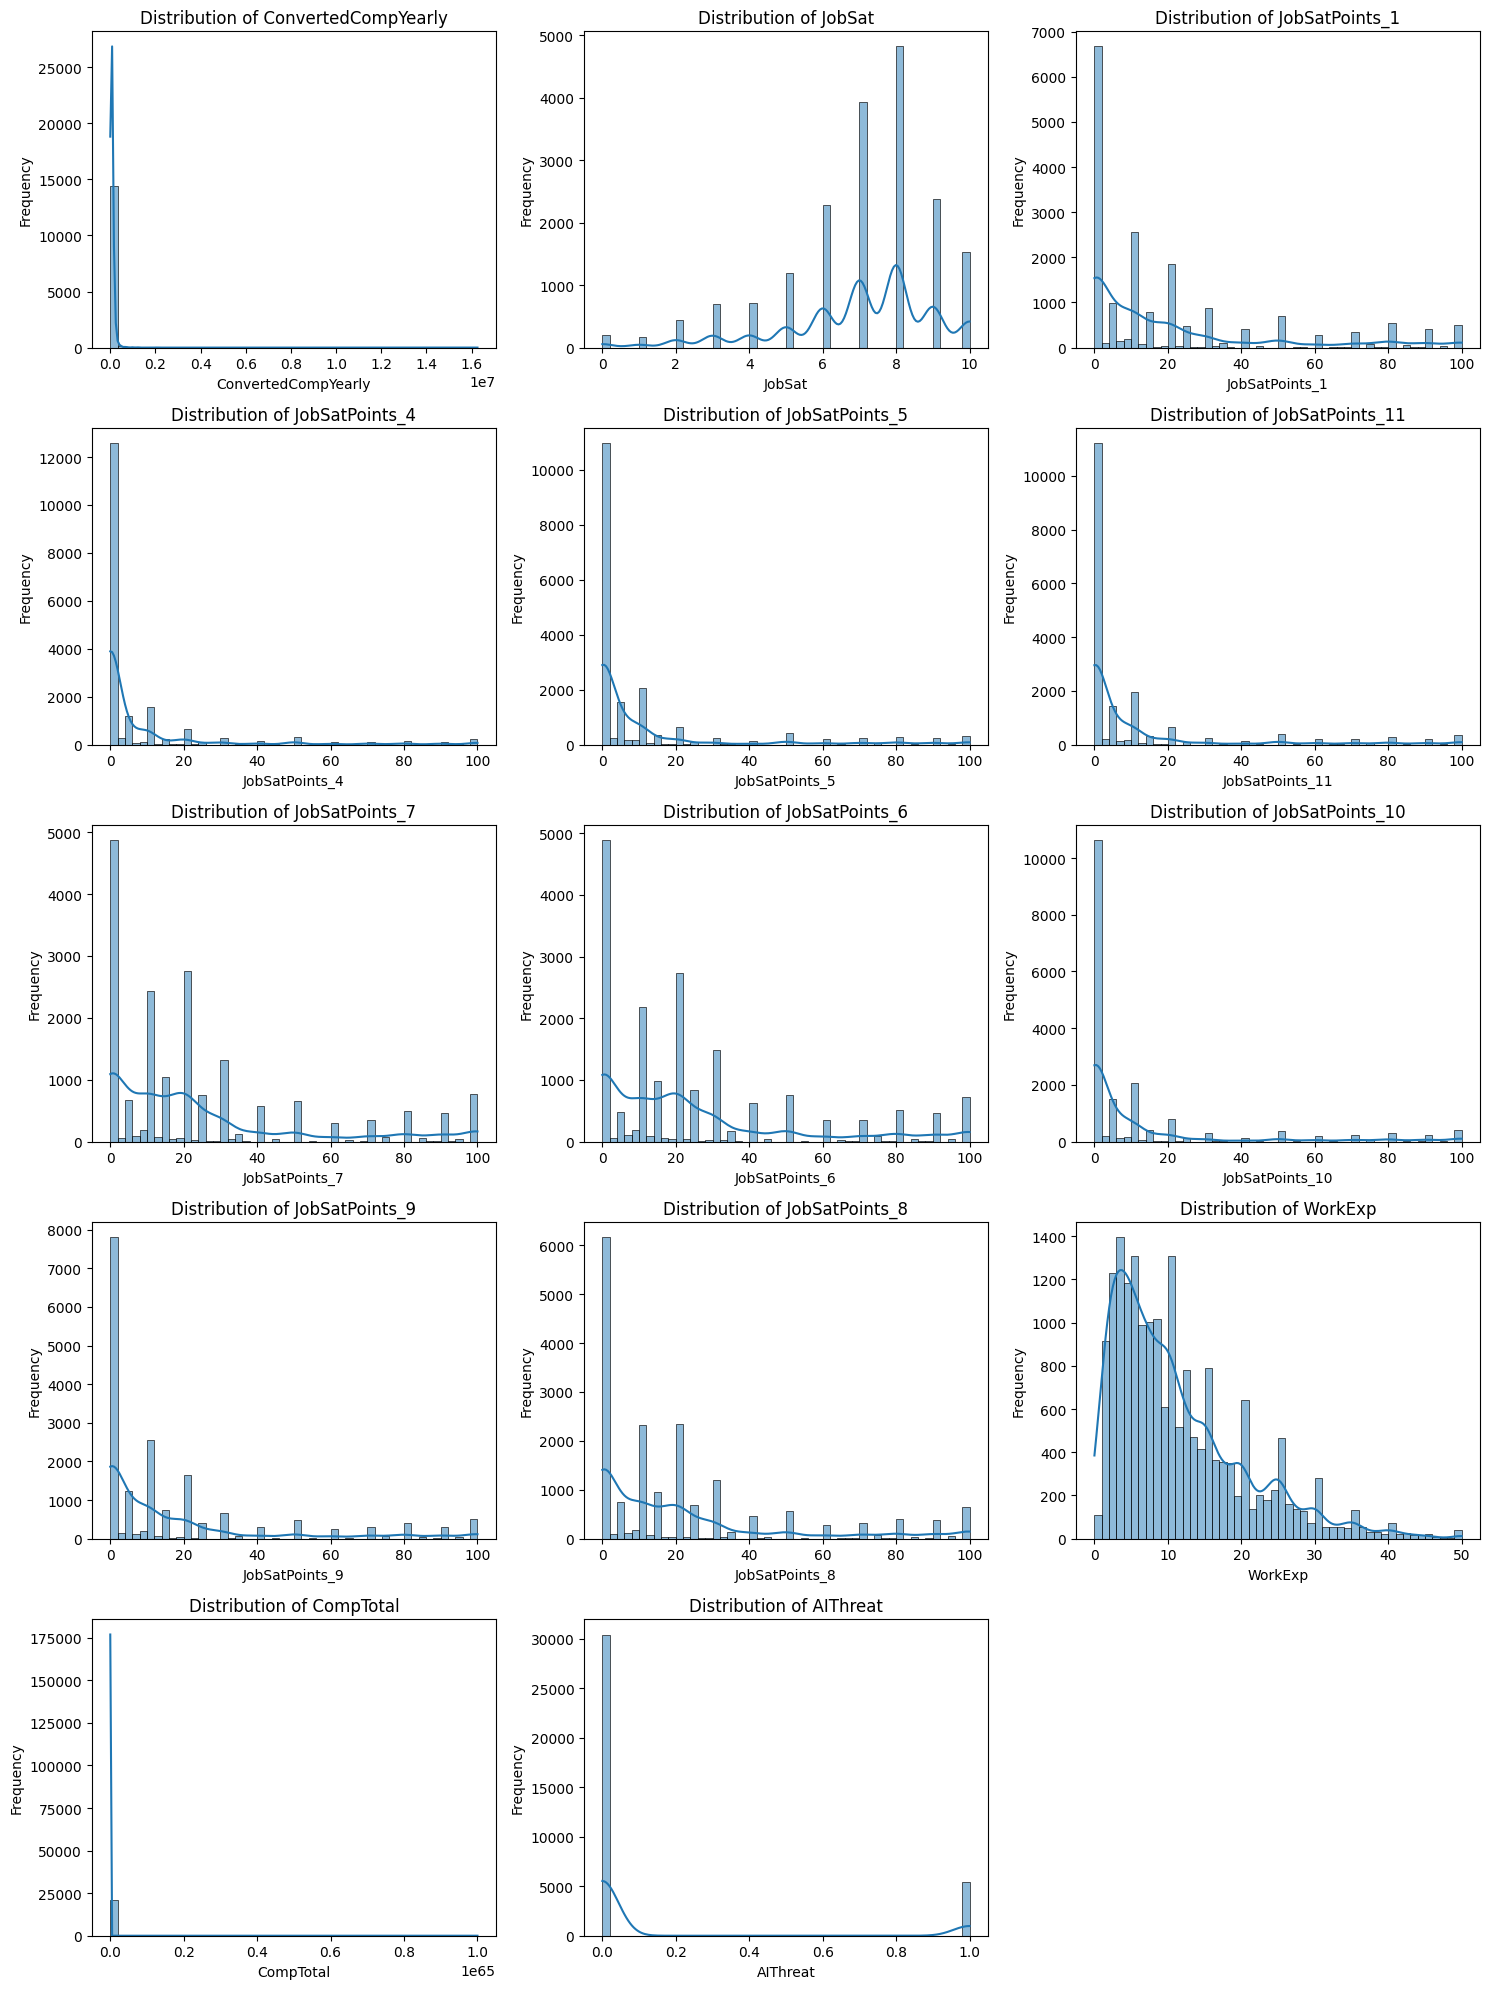

In [ ]:
n_cols = 3  # Number of columns for subplots
n_rows = (len(caracteristicas_numericas_T) + n_cols - 1) // n_cols # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(caracteristicas_numericas_T):
    if feature in df_final.columns:
        sns.histplot(df_final[feature], kde=True, ax=axes[i], bins=50) # Added bins=50 to prevent error
        axes[i].set_title(f'Distribution of {feature}', fontsize=12)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Campos Categoricos

In [ ]:
for variable in caracteristicas_categoricas_T:
    print(df_final[variable].value_counts(dropna=False))

EmbeddedHaveWorkedWith
NaN                                                          23135
Rasberry Pi                                                   2430
Arduino;Rasberry Pi                                           1325
Arduino                                                       1176
Cargo                                                          556
                                                             ...  
Cargo;MSVC;Ninja                                                 1
build2;Catch2;Cargo;Rasberry Pi                                  1
Boost.Test;Cargo;cppunit                                         1
Arduino;Boost.Test;build2;Catch2;GNU GCC;PlatformIO;SCons        1
Arduino;Cargo;GNU GCC;LLVM's Clang;Meson;Ninja                   1
Name: count, Length: 1117, dtype: int64
Knowledge_9
NaN                           18505
Agree                          4445
Neither agree nor disagree     3879
Strongly disagree              3702
Disagree                       3493
Strongly

In [ ]:
categoricas = []

for variable in caracteristicas_categoricas_T:
    unique_values = df[variable].nunique(dropna=False)
    if unique_values < 5:
        categoricas.append(variable)

print("Categorical features with less than 10 unique categories:")
for col in caracteristicas_categoricas_T:
    if df_final[col].nunique() < 5:
        print(f"- {col}: {df_final[col].nunique()} unique categories")

Categorical features with less than 10 unique categories:
- ProfessionalCloud: 3 unique categories
- ICorPM: 2 unique categories
- BuildvsBuy: 3 unique categories
- TBranch: 2 unique categories
- PurchaseInfluence: 3 unique categories
- RemoteWork: 3 unique categories
- SurveyEase: 3 unique categories
- SurveyLength: 3 unique categories
- SOAccount: 3 unique categories
- Check: 1 unique categories
- AISelect: 2 unique categories


In [ ]:
enc = OneHotEncoder(drop='first').fit(df_final[categoricas])
df_cat = enc.transform(df_final[categoricas]).toarray()
categorical_one_hot = enc.get_feature_names_out(categoricas)
print(categorical_one_hot)
df_cat = pd.DataFrame(df_cat, columns=categorical_one_hot)

['ProfessionalCloud_Hybrid (on-prem and cloud)'
 'ProfessionalCloud_On-prem' 'ProfessionalCloud_nan'
 'ICorPM_People manager' 'ICorPM_nan'
 'BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product'
 'BuildvsBuy_Out-of-the-box is ready to go with little need for customization'
 'BuildvsBuy_nan' 'TBranch_Yes' 'TBranch_nan'
 'PurchaseInfluence_I have little or no influence'
 'PurchaseInfluence_I have some influence' 'PurchaseInfluence_nan'
 'RemoteWork_In-person' 'RemoteWork_Remote' 'RemoteWork_nan'
 'SurveyEase_Easy' 'SurveyEase_Neither easy nor difficult'
 'SurveyEase_nan' 'SurveyLength_Too long' 'SurveyLength_Too short'
 'SurveyLength_nan' "SOAccount_Not sure/can't remember" 'SOAccount_Yes'
 'SOAccount_nan' 'AISelect_Yes']


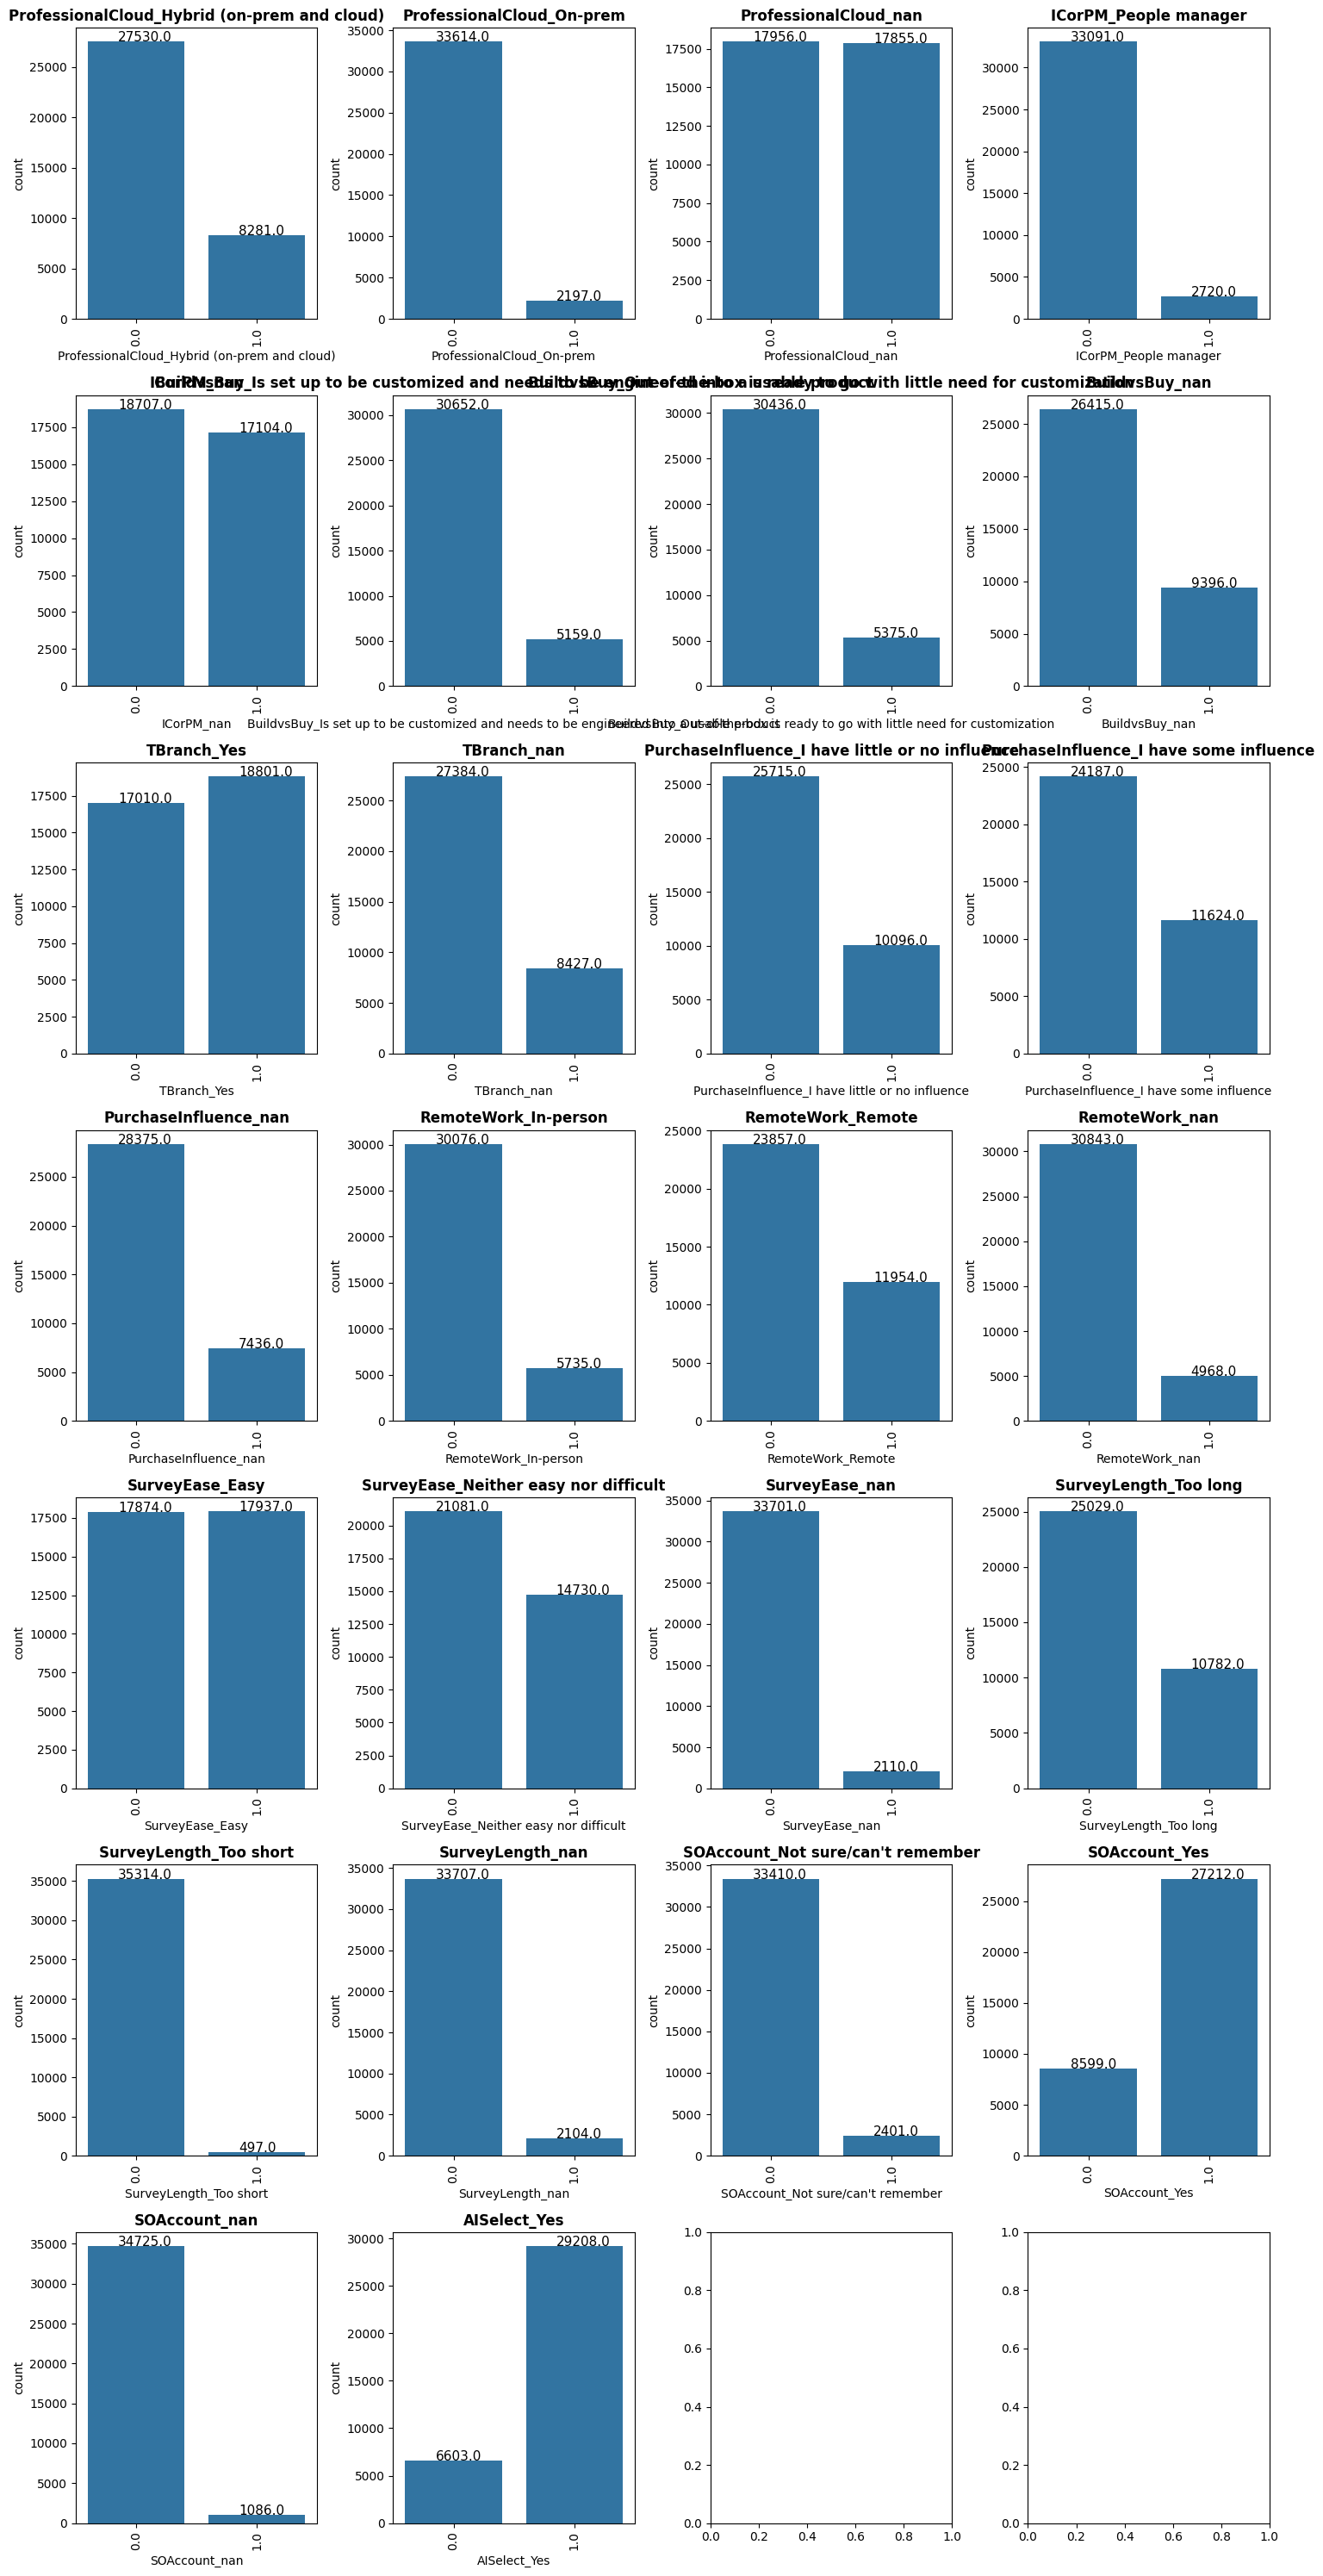

In [ ]:
fig, ax = plt.subplots(7, 4, figsize=(15, 30))
#fig.suptitle('Caracteristicas Categoricas')
for variable, subplot in zip(df_cat.columns, ax.flatten()):
    ax=sns.countplot(x=df_cat[variable], ax=subplot)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.15), size=11)
    ax=ax.set_title(variable,fontsize = 12, fontweight='bold')

    for label in subplot.get_xticklabels():
        label.set_rotation(90)


fig.tight_layout()

# Consolidar Categoricas y numericas

In [ ]:
df_num= df_final[caracteristicas_numericas_T]
df_cat.reset_index(drop=True, inplace=True)
df_num.reset_index(drop=True, inplace=True)

df_onehot = df_cat.join(df_num)
print(df_onehot.shape)
df_onehot.index = df.index
df_onehot.head()


(35811, 40)


,ProfessionalCloud_Hybrid (on-prem and cloud),ProfessionalCloud_On-prem,ProfessionalCloud_nan,ICorPM_People manager,ICorPM_nan,BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product,BuildvsBuy_Out-of-the-box is ready to go with little need for customization,BuildvsBuy_nan,TBranch_Yes,TBranch_nan,...,JobSatPoints_5,JobSatPoints_11,JobSatPoints_7,JobSatPoints_6,JobSatPoints_10,JobSatPoints_9,JobSatPoints_8,WorkExp,CompTotal,AIThreat
ResponseId,,,,,,,,,,,,,,,,,,,,,
4,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,10.0000,25.0000,0.0000,15.0000,0.0000,15.0000,NaN,0
17,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Imputar datos

In [ ]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35811 entries, 4 to 65433
Data columns (total 40 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   ProfessionalCloud_Hybrid (on-prem and cloud)                                            35811 non-null  float64
 1   ProfessionalCloud_On-prem                                                               35811 non-null  float64
 2   ProfessionalCloud_nan                                                                   35811 non-null  float64
 3   ICorPM_People manager                                                                   35811 non-null  float64
 4   ICorPM_nan                                                                              35811 non-null  float64
 5   BuildvsBuy_Is set up to be customized and needs to be engineered into a 

In [ ]:
for columna in df_onehot.columns:
    df_onehot[columna] = df_onehot[columna].fillna(0)

df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35811 entries, 4 to 65433
Data columns (total 40 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   ProfessionalCloud_Hybrid (on-prem and cloud)                                            35811 non-null  float64
 1   ProfessionalCloud_On-prem                                                               35811 non-null  float64
 2   ProfessionalCloud_nan                                                                   35811 non-null  float64
 3   ICorPM_People manager                                                                   35811 non-null  float64
 4   ICorPM_nan                                                                              35811 non-null  float64
 5   BuildvsBuy_Is set up to be customized and needs to be engineered into a 

# Metricas

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns

    # Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(), 6)))
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)
        woeDF = pd.concat([woeDF, d], axis=0)

        if show_woe:
            print(d)

    # Sort the newDF DataFrame by IV in descending order
    newDF = newDF.sort_values(by='IV', ascending=False).reset_index(drop=True)

    return newDF, woeDF

# Uso de la función
iv, woe = iv_woe(df_onehot, target= Variable_Objetivo[0], bins=20)

Information value of ProfessionalCloud_Hybrid (on-prem and cloud) is 0.011067
Information value of ProfessionalCloud_On-prem is 0.007504
Information value of ProfessionalCloud_nan is 0.030053
Information value of ICorPM_People manager is 0.010231
Information value of ICorPM_nan is 0.026281
Information value of BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product is 0.002329
Information value of BuildvsBuy_Out-of-the-box is ready to go with little need for customization is 0.000486
Information value of BuildvsBuy_nan is 0.039522
Information value of TBranch_Yes is 0.026015
Information value of TBranch_nan is 0.0607
Information value of PurchaseInfluence_I have little or no influence is 0.00176
Information value of PurchaseInfluence_I have some influence is 0.021285
Information value of PurchaseInfluence_nan is 0.047335
Information value of RemoteWork_In-person is 0.000187
Information value of RemoteWork_Remote is 0.001303
Information value of RemoteWork

/tmp/ipython-input-753366009.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
/tmp/ipython-input-753366009.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
/tmp/ipython-input-753366009.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["

In [ ]:
variables_seleccionadas_T=iv
variables_seleccionadas_T.reset_index(drop=True, inplace=True)
variables_seleccionadas_T.head(50)

,Variable,IV
0,JobSat,0.0759
1,TBranch_nan,0.0607
2,CompTotal,0.0568
3,RemoteWork_nan,0.0516
4,PurchaseInfluence_nan,0.0473
5,BuildvsBuy_nan,0.0395
6,ConvertedCompYearly,0.0389
7,WorkExp,0.0310
8,ProfessionalCloud_nan,0.0301
9,JobSatPoints_6,0.0299


# Separar la base en entrenamiento y testeo

In [ ]:
X = df_onehot.drop(labels=Variable_Objetivo[0], axis=1)
y = df_onehot[Variable_Objetivo[0]].astype('int64')
# global variables
seed = 201

In [ ]:
seed = 201

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)

In [ ]:
X_train.shape

(25067, 39)

In [ ]:
X_test.shape

(10744, 39)

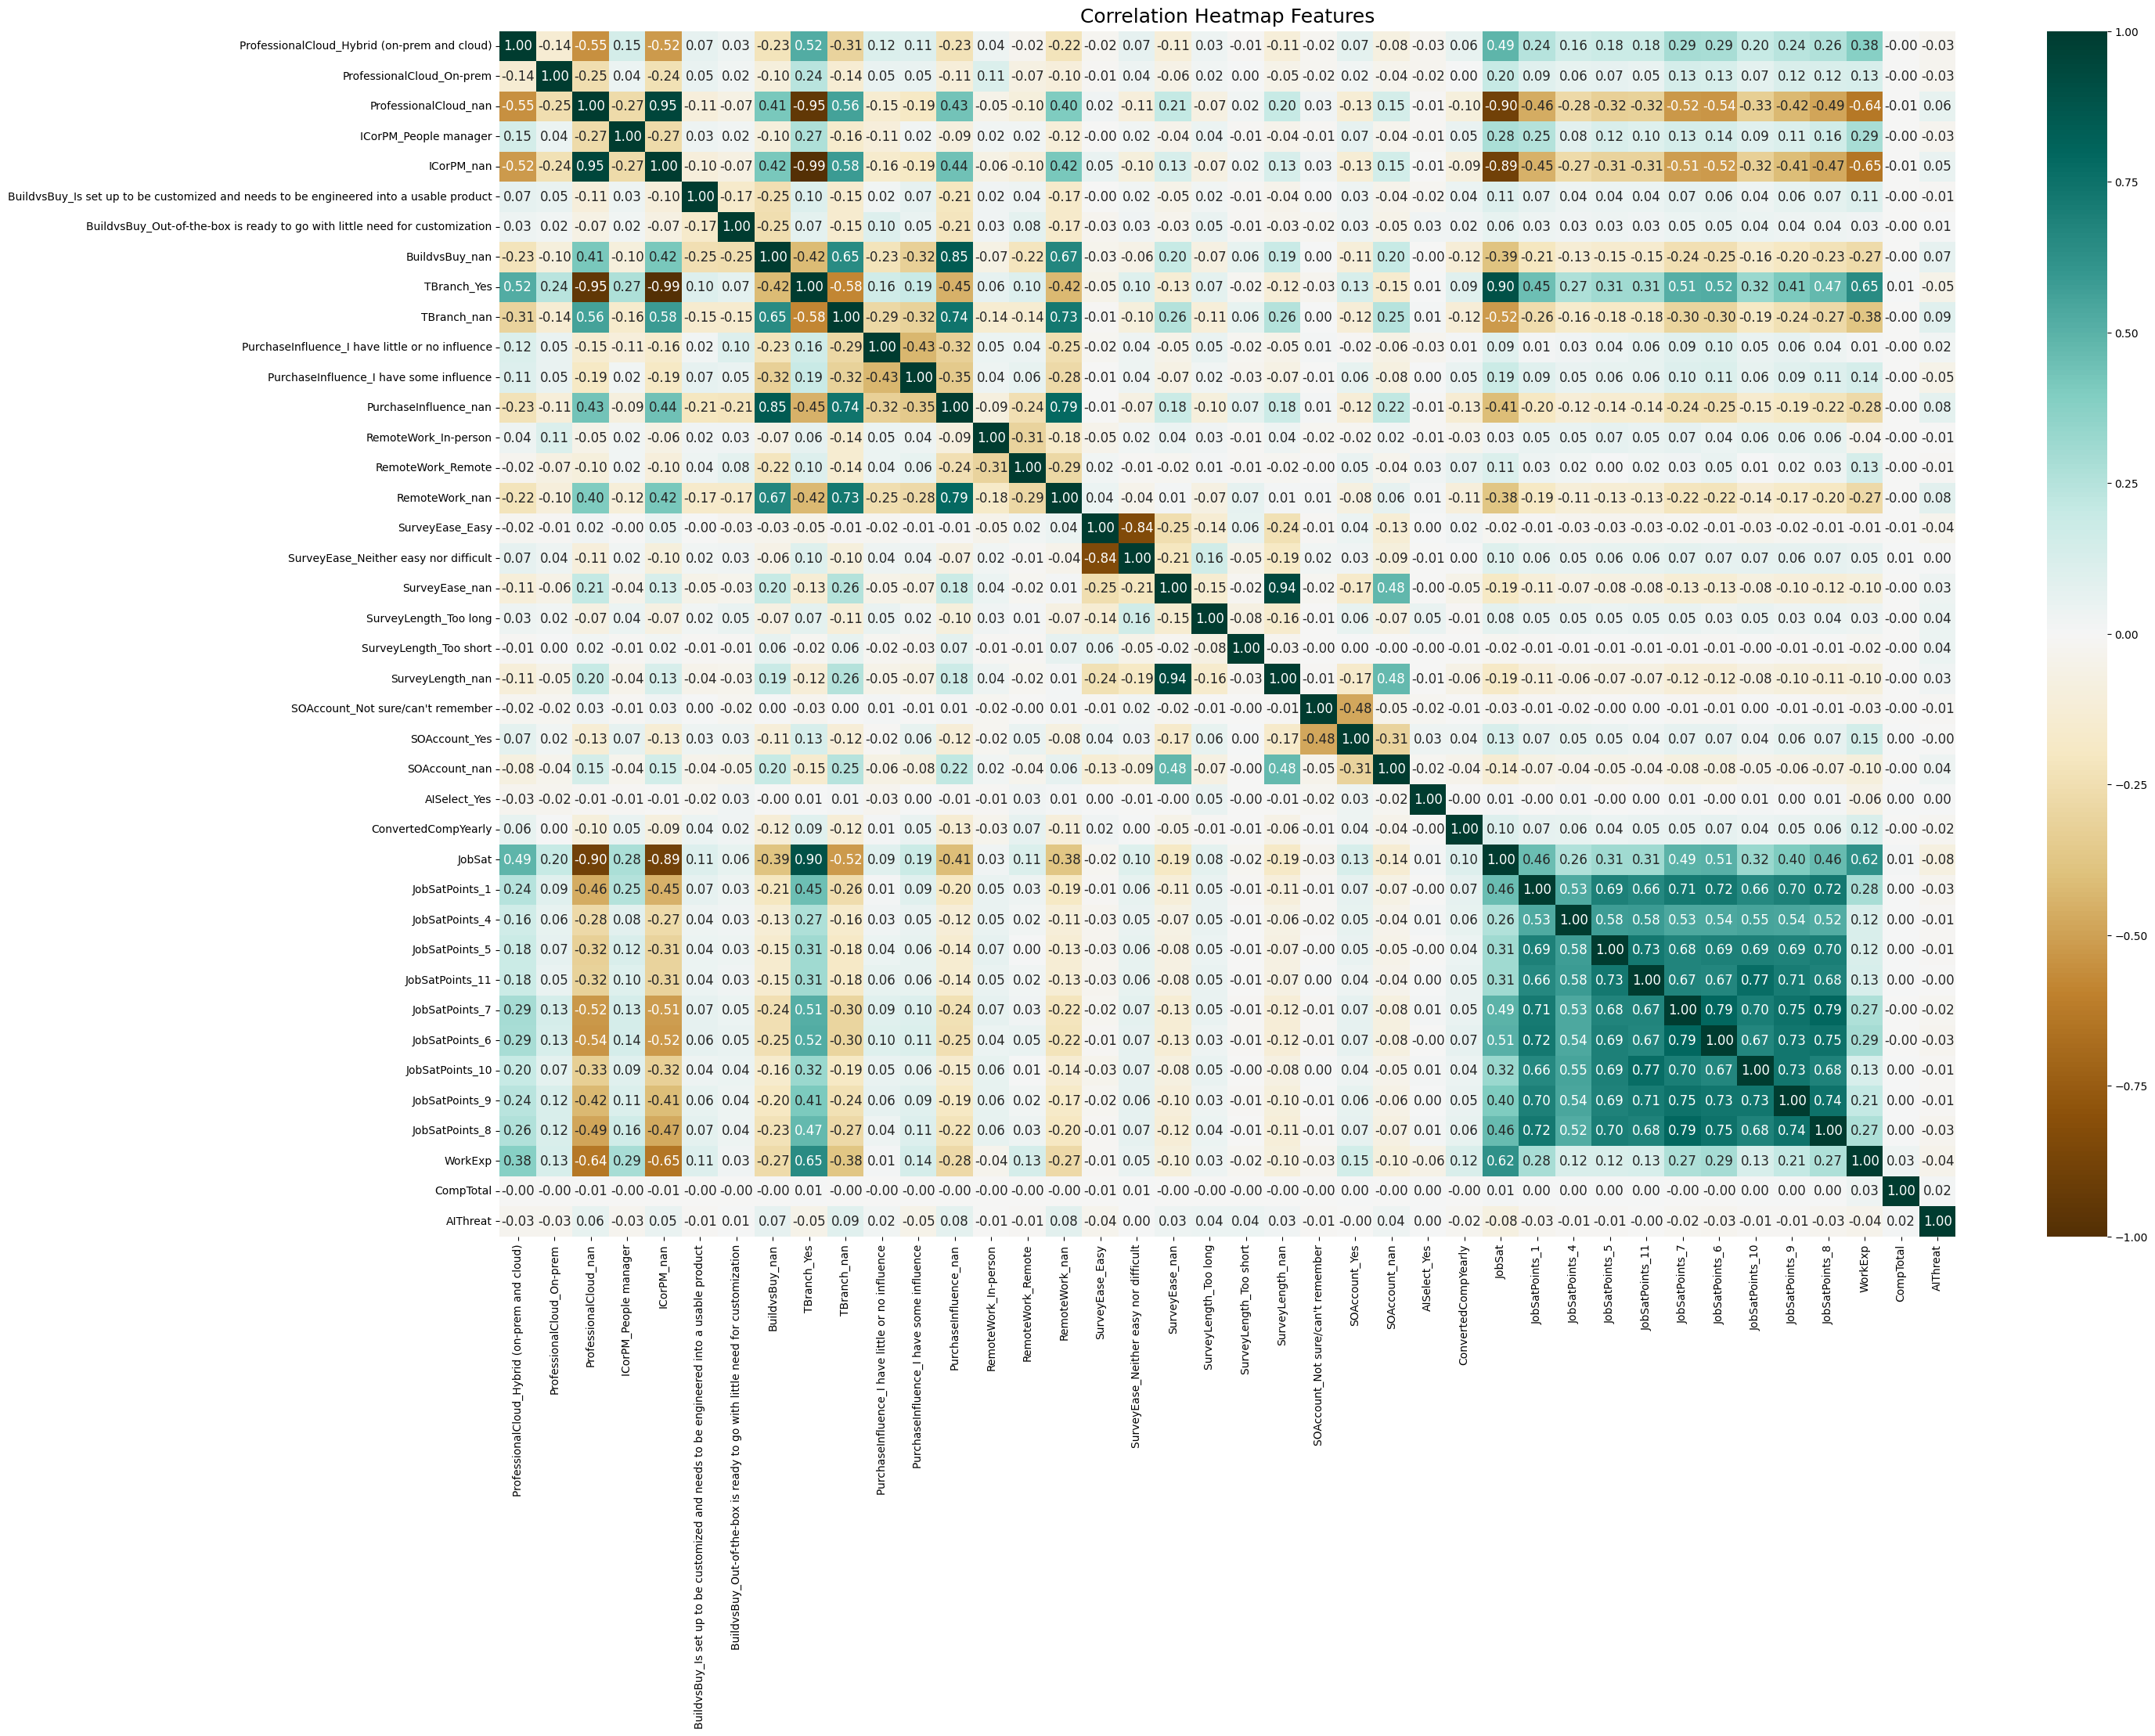

In [ ]:
Caracteristicas_RFE_final = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
plt.figure(figsize=(30,20))
heatmap = sns.heatmap(Caracteristicas_RFE_final.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',fmt='.2f',  annot_kws={'size': 12})
heatmap.set_title('Correlation Heatmap Features', fontdict={'fontsize':18}, pad=8);

Si una correlación es mayor que 0.6 (positiva) o menor que -0.6 (negativa), generalmente se considera una correlación fuerte. por lo tanto es necesario eliminar una de las variables para evitar problemas de multicolinealidad y redundancia en tu modelo.

In [ ]:
correlation_matrix = Caracteristicas_RFE_final.corr()

num_rows, num_cols = correlation_matrix.shape

high_correlation_pairs = []

for i in range(num_rows):
    for j in range(i+1, num_cols):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.6:
            print(f"Correlación entre {correlation_matrix.columns[i]} y {correlation_matrix.columns[j]}: {corr_value}")
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print("\nHigh correlation pairs stored:")
for pair in high_correlation_pairs:
    print(pair)

Correlación entre ProfessionalCloud_nan y ICorPM_nan: 0.9520461327212996
Correlación entre ProfessionalCloud_nan y TBranch_Yes: -0.952837646645672
Correlación entre ProfessionalCloud_nan y JobSat: -0.8963852691967513
Correlación entre ProfessionalCloud_nan y WorkExp: -0.6357918264070472
Correlación entre ICorPM_nan y TBranch_Yes: -0.9946569673266157
Correlación entre ICorPM_nan y JobSat: -0.8943736402999961
Correlación entre ICorPM_nan y WorkExp: -0.6481492880749086
Correlación entre BuildvsBuy_nan y TBranch_nan: 0.6457206295895562
Correlación entre BuildvsBuy_nan y PurchaseInfluence_nan: 0.8485429920605656
Correlación entre BuildvsBuy_nan y RemoteWork_nan: 0.6711360066710351
Correlación entre TBranch_Yes y JobSat: 0.8955233891269958
Correlación entre TBranch_Yes y WorkExp: 0.6482828807053784
Correlación entre TBranch_nan y PurchaseInfluence_nan: 0.7365139290978802
Correlación entre TBranch_nan y RemoteWork_nan: 0.7252154864448223
Correlación entre PurchaseInfluence_nan y RemoteWork_na

In [ ]:
columns_to_drop_set = set()
dropped_columns_details = []

already_removed_cols = set()

for pair in high_correlation_pairs:
    col1, col2 = pair

    # Check if col1 or col2 have already been marked for dropping or are not in the current X_train columns
    if col1 not in X_train.columns or col2 not in X_train.columns:
        if col1 not in X_train.columns and col1 not in already_removed_cols:
            already_removed_cols.add(col1)
        if col2 not in X_train.columns and col2 not in already_removed_cols:
            already_removed_cols.add(col2)
        continue

    # Case 1: One of the columns is the target variable
    if col1 == Variable_Objetivo[0]:
        if col2 not in columns_to_drop_set:
            columns_to_drop_set.add(col2)
            dropped_columns_details.append(f"Dropped '{col2}' due to high correlation with target '{col1}'.")
            already_removed_cols.add(col2)
    elif col2 == Variable_Objetivo[0]:
        if col1 not in columns_to_drop_set:
            columns_to_drop_set.add(col1)
            dropped_columns_details.append(f"Dropped '{col1}' due to high correlation with target '{col2}'.")
            already_removed_cols.add(col1)
    # Case 2: Neither column is the target variable
    else:
        # Ensure both columns are still in the DataFrame and not already marked for dropping
        if (col1 in X_train.columns and col1 not in columns_to_drop_set) and \
           (col2 in X_train.columns and col2 not in columns_to_drop_set):

            iv_col1 = variables_seleccionadas_T[variables_seleccionadas_T['Variable'] == col1]['IV'].iloc[0]
            iv_col2 = variables_seleccionadas_T[variables_seleccionadas_T['Variable'] == col2]['IV'].iloc[0]

            if iv_col1 < iv_col2:
                columns_to_drop_set.add(col1)
                dropped_columns_details.append(f"Dropped '{col1}' (IV={iv_col1:.4f}) due to high correlation with '{col2}' (IV={iv_col2:.4f}).")
                already_removed_cols.add(col1)
            elif iv_col2 < iv_col1:
                columns_to_drop_set.add(col2)
                dropped_columns_details.append(f"Dropped '{col2}' (IV={iv_col2:.4f}) due to high correlation with '{col1}' (IV={iv_col1:.4f}).")
                already_removed_cols.add(col2)
            else: # If IVs are equal, drop col2 as a tie-breaker
                columns_to_drop_set.add(col2)
                dropped_columns_details.append(f"Dropped '{col2}' (IV={iv_col2:.4f}) due to high correlation with '{col1}' (IV={iv_col1:.4f}) (tie-breaker).")
                already_removed_cols.add(col2)

print("Columns to be dropped:", columns_to_drop_set)
print("Dropped columns details:")
for detail in dropped_columns_details:
    print(detail)

# Drop the identified columns from X_train
X_train = X_train.drop(columns=list(columns_to_drop_set), errors='ignore')

print(f"New shape of X_train: {X_train.shape}")

Columns to be dropped: {'TBranch_Yes', 'ProfessionalCloud_nan', 'SurveyEase_Neither easy nor difficult', 'SurveyLength_nan', 'JobSatPoints_5', 'RemoteWork_nan', 'JobSatPoints_7', 'JobSatPoints_1', 'JobSatPoints_10', 'JobSatPoints_8', 'WorkExp', 'PurchaseInfluence_nan', 'ICorPM_nan', 'JobSatPoints_11', 'JobSatPoints_9', 'BuildvsBuy_nan'}
Dropped columns details:
Dropped 'ICorPM_nan' (IV=0.0263) due to high correlation with 'ProfessionalCloud_nan' (IV=0.0301).
Dropped 'TBranch_Yes' (IV=0.0260) due to high correlation with 'ProfessionalCloud_nan' (IV=0.0301).
Dropped 'ProfessionalCloud_nan' (IV=0.0301) due to high correlation with 'JobSat' (IV=0.0759).
Dropped 'BuildvsBuy_nan' (IV=0.0395) due to high correlation with 'TBranch_nan' (IV=0.0607).
Dropped 'PurchaseInfluence_nan' (IV=0.0473) due to high correlation with 'TBranch_nan' (IV=0.0607).
Dropped 'RemoteWork_nan' (IV=0.0516) due to high correlation with 'TBranch_nan' (IV=0.0607).
Dropped 'SurveyEase_Neither easy nor difficult' (IV=0.00

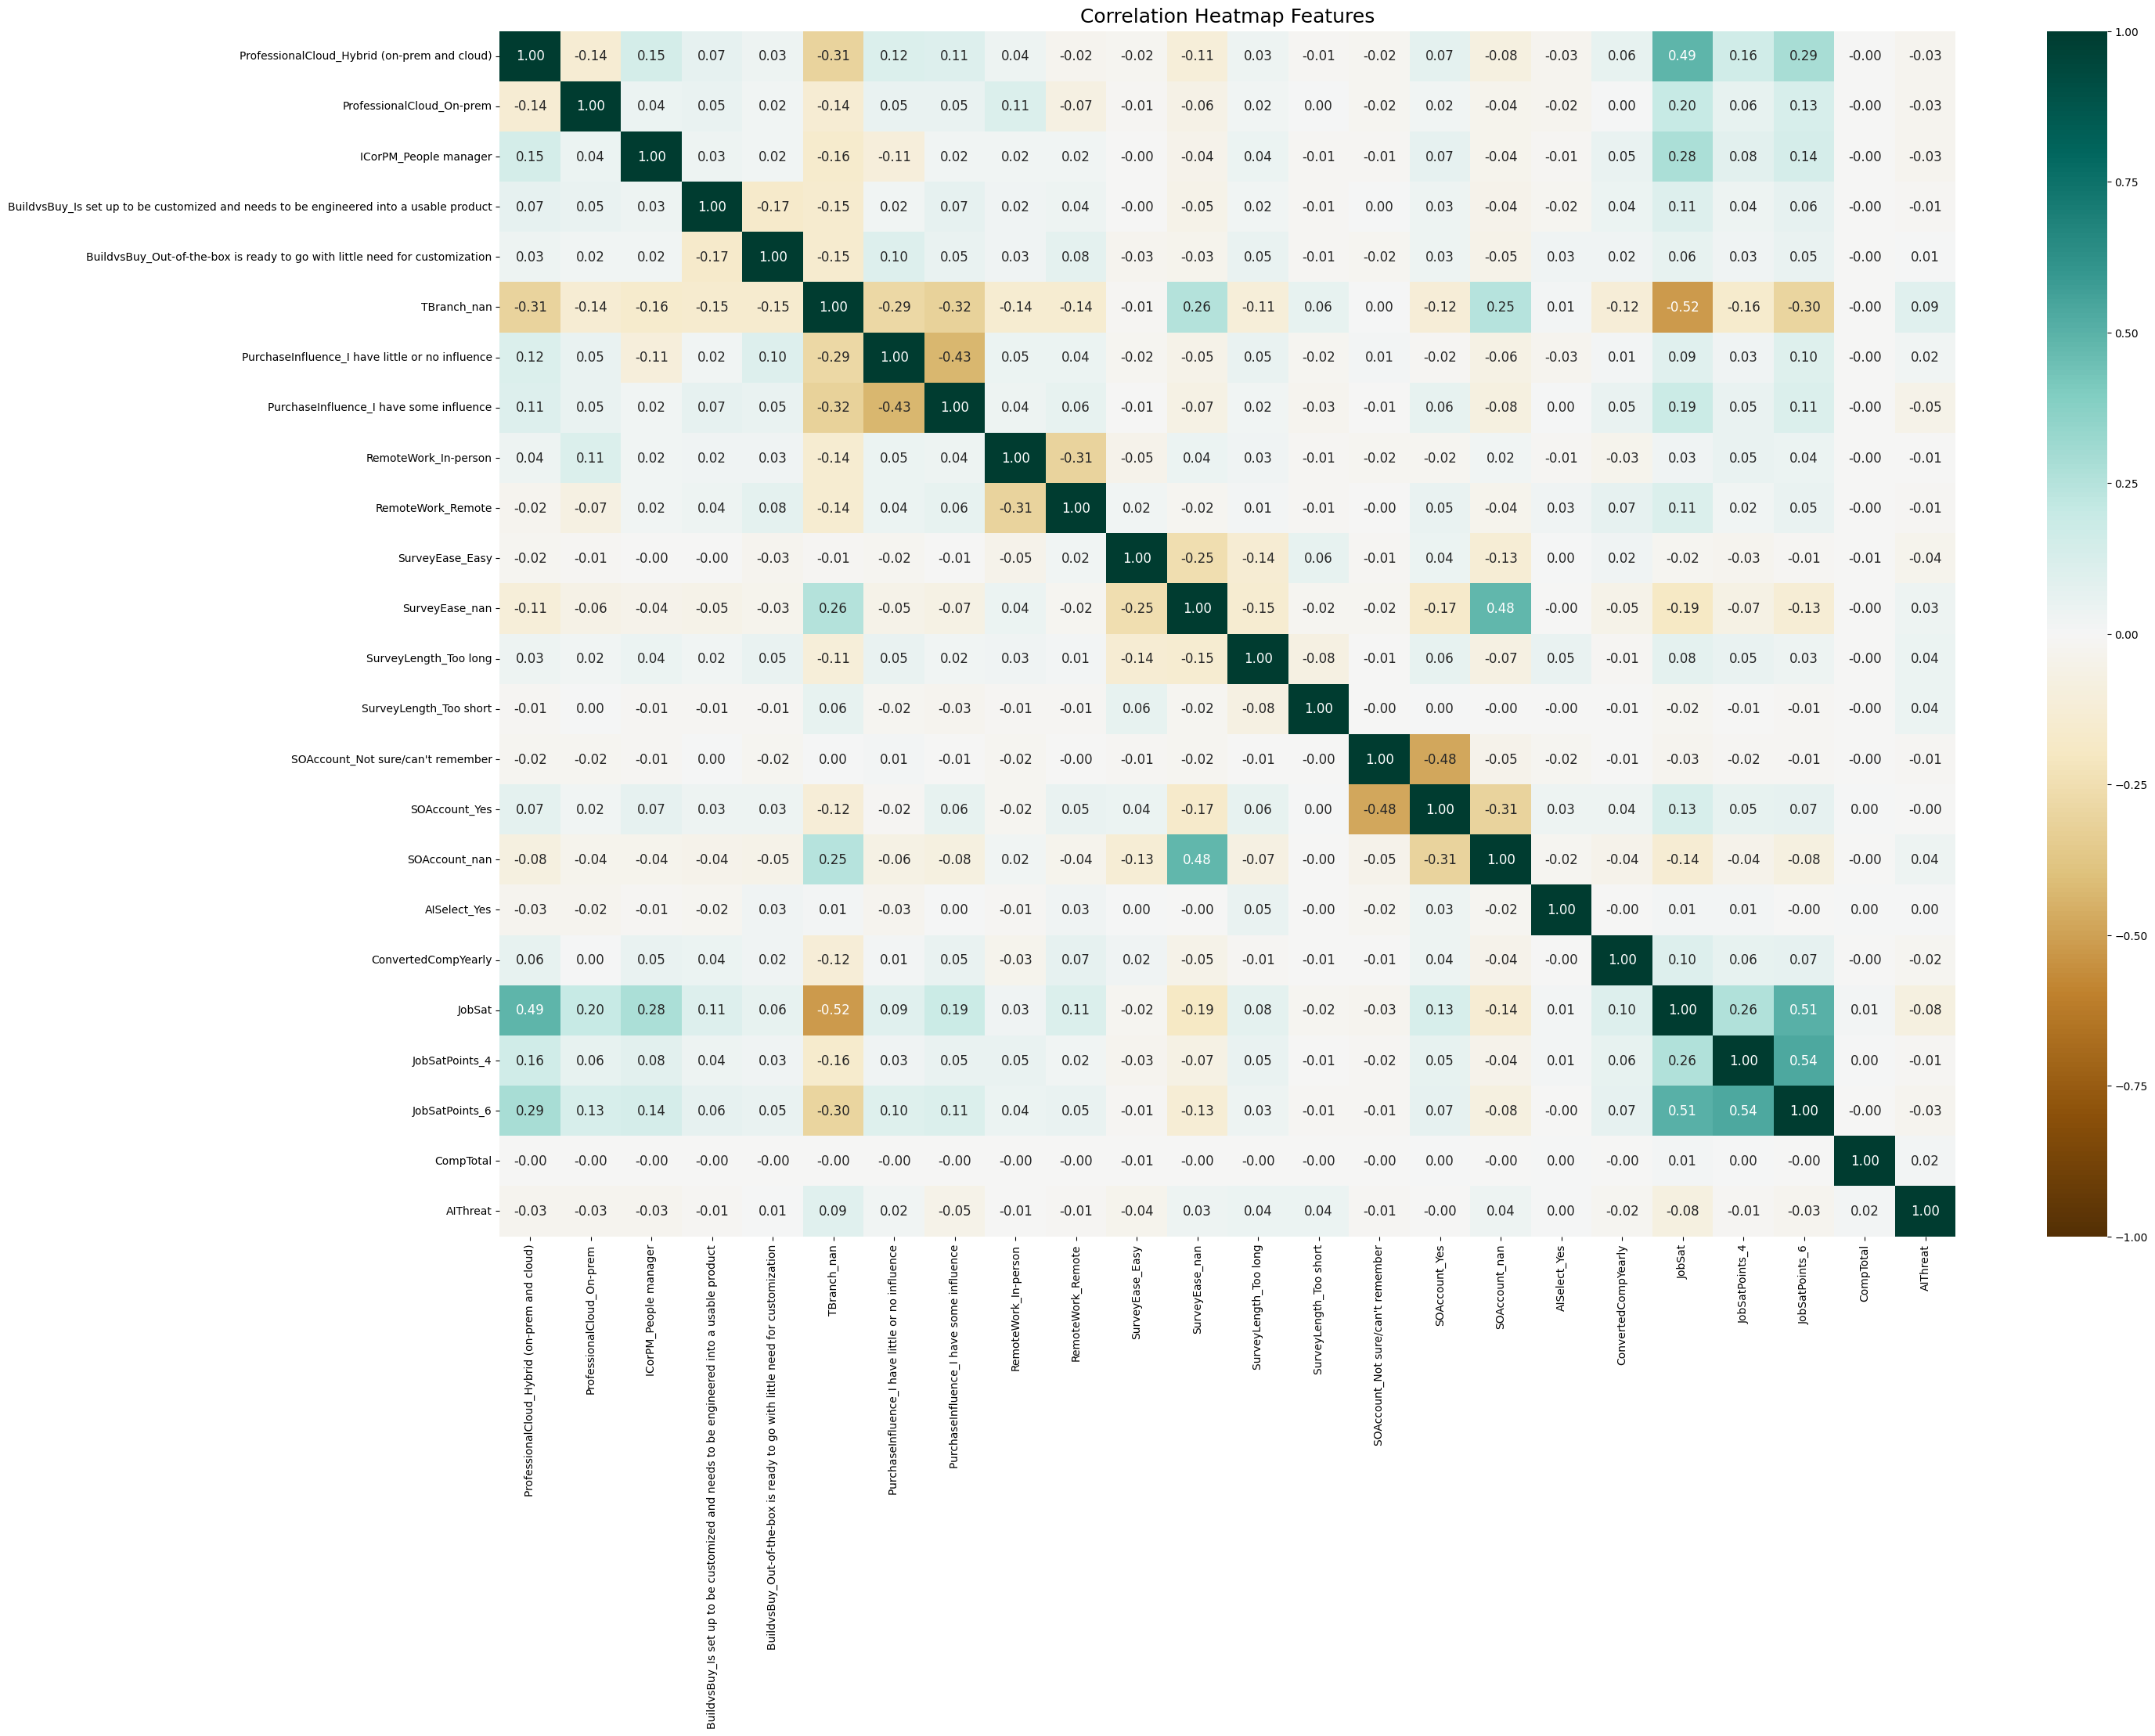

In [ ]:
Caracteristicas_RFE_final = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
plt.figure(figsize=(30,20))
heatmap = sns.heatmap(Caracteristicas_RFE_final.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',fmt='.2f',  annot_kws={'size': 12})
heatmap.set_title('Correlation Heatmap Features', fontdict={'fontsize':18}, pad=8);

In [ ]:
variables=X_train.columns
X_train=X_train[variables]
X_test=X_test[variables]

# Resumen de la Exploración y Limpieza de Datos

Este resumen detalla los pasos clave realizados durante la exploración y limpieza de los datos, preparando el conjunto de datos para el modelado.

### 1. Carga Inicial de Datos
El proceso comenzó cargando el archivo `survey_results_public.csv` en un DataFrame de pandas llamado `df`. Posteriormente, la columna `ResponseId` fue establecida como índice del DataFrame para facilitar la identificación y manejo de las entradas individuales.

### 2. Tratamiento de la Variable Objetivo 'AIThreat'
La variable objetivo, `AIThreat`, que representa la percepción de amenaza de la IA, fue sometida a un riguroso proceso de limpieza:
- Primero, se eliminaron las filas donde `AIThreat` tenía valores nulos, lo que redujo el tamaño del dataset.
- Luego, se filtraron las respuestas que indicaban 'I'm not sure', dejando solo las categorías 'No' y 'Yes'.
- Finalmente, estas categorías fueron convertidas a un formato binario numérico: 'No' se mapeó a `0` y 'Yes' a `1`, preparando la variable para algoritmos de clasificación.

### 3. Análisis y Eliminación de Columnas con Valores Faltantes
Se realizó un análisis exhaustivo de los valores faltantes en todas las columnas del DataFrame. Se calculó el porcentaje de valores nulos para cada característica. Se estableció un umbral del 70%, y todas las columnas que superaban este porcentaje de datos faltantes fueron eliminadas del análisis para evitar la introducción de ruido o la necesidad de imputaciones excesivas.

### 4. Codificación One-Hot de Características Categóricas
Las características categóricas restantes en el DataFrame final fueron identificadas. Para aquellas con una cardinalidad baja (menos de 5 valores únicos), se aplicó la codificación One-Hot utilizando `OneHotEncoder` de `sklearn`. Se utilizó el parámetro `drop='first'` para eliminar la primera categoría de cada variable codificada, lo que ayuda a prevenir la multicolinealidad y la redundancia en el modelo resultante.

### 5. Imputación de Valores Numéricos Faltantes
Para las columnas numéricas que aún contenían valores faltantes después de los pasos anteriores, se optó por la imputación simple, rellenando todos los valores `NaN` con `0`. Esta estrategia asegura que el DataFrame no contenga nulos antes de la fase de modelado, simplificando el proceso.

### 6. Creación de Métricas de Information Value (IV)
Se calculó la métrica de Information Value (IV) para cada característica restante. El IV es crucial para evaluar el poder predictivo de cada variable en relación con la variable objetivo. Esta métrica fue utilizada posteriormente en el proceso de selección de características.

### 7. Selección de Características Basada en Correlación
Se realizó un análisis de correlación exhaustivo sobre el conjunto de entrenamiento (`X_train`). Se identificaron pares de características con una correlación fuerte (valor absoluto mayor a 0.6). Para mitigar la multicolinealidad, se aplicó una estrategia de eliminación: entre dos características altamente correlacionadas, se eliminó aquella con el menor valor de Information Value (IV). Este proceso se repitió iterativamente hasta que no quedaron pares de características con una correlación fuerte, asegurando un conjunto de características más independiente y robusto para el modelado.

### Conclusión
Tras estos extensos pasos de exploración y limpieza, el conjunto de datos ha sido cuidadosamente preparado. La variable objetivo ha sido binarizada, las columnas problemáticas han sido eliminadas, las características categóricas han sido codificadas, los valores numéricos faltantes han sido imputados, y la multicolinealidad se ha abordado mediante la selección de características basada en IV y correlación. El DataFrame está ahora limpio, preprocesado y listo para la fase de modelado.

# Modelamiento

In [ ]:
log_reg = LogisticRegression(random_state=seed, solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print(f"Logistic Regression Model Performance:")
print(f"  Accuracy: {accuracy_lr:.4f}")
print(f"  Precision: {precision_lr:.4f}")
print(f"  Recall: {recall_lr:.4f}")
print(f"  F1-Score: {f1_lr:.4f}")
print(f"  ROC AUC Score: {roc_auc_lr:.4f}")

Logistic Regression Model Performance:
  Accuracy: 0.4117
  Precision: 0.1318
  Recall: 0.4935
  F1-Score: 0.2080
  ROC AUC Score: 0.5000


## Análisis del Rendimiento del Modelo de Regresión Logística

El modelo de Regresión Logística ha sido evaluado con las siguientes métricas de rendimiento:

*   **Accuracy (Precisión General):** `0.4117`
*   **Precision (Precisión):** `0.1318`
*   **Recall (Sensibilidad):** `0.4935`
*   **F1-Score:** `0.2080`
*   **ROC AUC Score:** `0.5000`

### Interpretación de las Métricas:

1.  **Accuracy (Precisión General):** Con un valor de `0.4117`, la precisión general indica que aproximadamente el 41.17% de todas las predicciones del modelo (tanto de 'No amenaza de IA' como de 'Sí amenaza de IA') fueron correctas. Este valor es bastante bajo, sugiriendo que el modelo no es muy bueno en la clasificación general. Dada la clase mayoritaria (0 - No), una precisión del 41% podría ser incluso peor que un modelo que siempre predice la clase mayoritaria si la clase minoritaria es rara.

2.  **Precision (Precisión) y Recall (Sensibilidad):**
    *   **Precision:** Con `0.1318`, solo el 13.18% de las instancias que el modelo predijo como 'Sí amenaza de IA' (clase 1) fueron realmente 'Sí amenaza de IA'. Esto es un valor muy bajo, lo que significa que cuando el modelo identifica una amenaza, es muy probable que esté equivocado. Hay muchos falsos positivos.
    *   **Recall:** Con `0.4935`, el modelo logró identificar el 49.35% de todas las instancias que realmente eran 'Sí amenaza de IA'. Esto significa que, de todas las personas que realmente perciben una amenaza de IA, el modelo capturó casi la mitad. Esto es moderado, pero aún insuficiente.

    La combinación de una precisión muy baja y un recall moderado sugiere que el modelo es muy propenso a los falsos positivos. Es decir, predice que hay una amenaza de IA en muchos casos donde no la hay, aunque logra capturar una parte de las amenazas reales.

3.  **F1-Score:** El F1-Score de `0.2080` es un promedio armónico de la precisión y el recall. Un valor tan bajo confirma que el modelo no está funcionando bien en la clasificación de la clase minoritaria ('Sí amenaza de IA'), ya que tanto la precisión como el recall son componentes esenciales y la precisión es particularmente deficiente. Un F1-Score bajo es especialmente preocupante en problemas de clasificación desequilibrada.

4.  **ROC AUC Score:** Un ROC AUC Score de `0.5000` es muy problemático. Un valor de 0.5 indica que el modelo no tiene mejor capacidad para distinguir entre las clases positiva y negativa que un clasificador aleatorio (lanzar una moneda al aire). Esto sugiere que las predicciones del modelo son esencialmente aleatorias en términos de separar las dos clases, lo cual es una debilidad crítica para un modelo de clasificación.

### Fortalezas y Debilidades:

*   **Fortalezas:** Lamentablemente, basándose en estas métricas, el modelo de Regresión Logística no demuestra fortalezas significativas en la predicción de la percepción de amenaza de la IA. Su recall moderado es la métrica menos desfavorable, pero su baja precisión lo invalida en gran medida.

*   **Debilidades:** Las principales debilidades son su muy baja precisión, un F1-Score deficiente, y un ROC AUC Score que indica un rendimiento aleatorio. Esto significa que el modelo genera una gran cantidad de falsos positivos y no es capaz de distinguir de manera confiable entre quienes perciben una amenaza de IA y quienes no. La precisión general también es muy baja.

In [ ]:
# Replace infinite values with NaN in training and test data (if any were missed or reintroduced)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define a reasonable range for float32 to prevent overflow, e.g., max/min value of float32
float32_max = np.finfo(np.float32).max
float32_min = np.finfo(np.float32).min

# Clip values to prevent overflow before casting to float32
X_train = X_train.clip(lower=float32_min, upper=float32_max)
X_test = X_test.clip(lower=float32_min, upper=float32_max)

# Convert dataframes to float32 to ensure consistent data types
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

xgb_model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss', missing=np.nan)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print(f"XGBoost Classifier Model Performance:")
print(f"  Accuracy: {accuracy_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall: {recall_xgb:.4f}")
print(f"  F1-Score: {f1_xgb:.4f}")
print(f"  ROC AUC Score: {roc_auc_xgb:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:05:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Model Performance:
  Accuracy: 0.8407
  Precision: 0.3077
  Recall: 0.0143
  F1-Score: 0.0273
  ROC AUC Score: 0.5893


## Explicación del Rendimiento del Modelo XGBoost

Las métricas de rendimiento para el modelo XGBoost son las siguientes:
- **Accuracy**: 0.8407
- **Precision**: 0.3077
- **Recall**: 0.0143
- **F1-Score**: 0.0273
- **ROC AUC Score**: 0.5893

Comparadas con la Regresión Logística:
- **Accuracy**: 0.4117
- **Precision**: 0.1318
- **Recall**: 0.4935
- **F1-Score**: 0.2080
- **ROC AUC Score**: 0.5000

### Análisis de las Métricas del Modelo XGBoost

1.  **Accuracy (Precisión General)**: Un Accuracy de 0.8407 significa que el modelo clasifica correctamente el 84.07% de las instancias totales. En el contexto de 'AIThreat' (0 para No, 1 para Sí), esto indica que la mayoría de las predicciones del modelo son correctas. Sin embargo, dado un posible desbalance de clases (como se observa en las `value_counts` de `AIThreat` en la etapa de EDA), un alto Accuracy puede ser engañoso si el modelo simplemente predice la clase mayoritaria la mayoría de las veces.

2.  **Precision (Precisión de Predicciones Positivas)**: Un Precision de 0.3077 significa que, de todas las instancias que el modelo predijo como 'Yes' (AIThreat=1), solo el 30.77% fueron realmente 'Yes'. Esto sugiere que el modelo tiene un número significativo de falsos positivos, es decir, predice que hay una amenaza de IA cuando en realidad no la hay.

3.  **Recall (Sensibilidad/Tasa de Verdaderos Positivos)**: Un Recall extremadamente bajo de 0.0143 indica que el modelo solo identificó correctamente el 1.43% de todas las instancias que realmente eran 'Yes' (AIThreat=1). Este es un punto crítico de debilidad. Significa que el modelo es muy deficiente en detectar la clase minoritaria, lo que podría ser inaceptable si el costo de no detectar una amenaza real de IA es alto.

4.  **F1-Score**: Un F1-Score de 0.0273 es el promedio armónico de Precision y Recall. Su valor muy bajo confirma que el modelo no está funcionando bien, especialmente debido a su bajo Recall. El F1-Score es útil cuando hay un desbalance de clases y es importante equilibrar Precision y Recall.

5.  **ROC AUC Score**: Un ROC AUC Score de 0.5893 indica la capacidad del modelo para distinguir entre las clases positiva y negativa. Un valor de 0.5 sugiere que el modelo no es mejor que una clasificación aleatoria. Un 0.5893 es ligeramente mejor que el azar, pero aún es bastante bajo y sugiere que el modelo tiene una capacidad discriminatoria limitada entre 'Yes' y 'No' para 'AIThreat'.

### Comparación con la Regresión Logística

| Métrica       | Regresión Logística | XGBoost Classifier |
| :------------ | :------------------ | :----------------- |
| Accuracy      | 0.4117              | **0.8407**         |
| Precision     | 0.1318              | **0.3077**         |
| Recall        | **0.4935**          | 0.0143             |
| F1-Score      | **0.2080**          | 0.0273             |
| ROC AUC Score | 0.5000              | **0.5893**         |

-   **Accuracy y Precision**: El modelo XGBoost muestra una mejora significativa en Accuracy y Precision en comparación con la Regresión Logística. Esto sugiere que XGBoost es mejor en clasificar correctamente el conjunto de datos en general y en que sus predicciones positivas sean realmente positivas.
-   **Recall**: Sin embargo, la Regresión Logística supera drásticamente a XGBoost en Recall. El Recall de 0.4935 para la Regresión Logística, aunque no excelente, es significativamente mejor que el 0.0143 de XGBoost. Esto implica que la Regresión Logística fue mucho más efectiva en identificar las instancias reales de 'AIThreat=1'.
-   **F1-Score**: La Regresión Logística tiene un F1-Score más alto, lo que indica un mejor equilibrio entre Precision y Recall que el modelo XGBoost, especialmente porque el Recall de XGBoost es muy bajo. El F1-Score de la Regresión Logística también está limitado por su baja Precision.
-   **ROC AUC Score**: El modelo XGBoost muestra un ROC AUC Score ligeramente mejor (0.5893 vs 0.5000), lo que indica una mejor capacidad de discriminación general entre las clases, aunque todavía no es un resultado fuerte.

### Fortalezas y Debilidades de XGBoost

**Fortalezas**:
-   **Mayor Precisión General (Accuracy)**: El modelo XGBoost tiene un Accuracy mucho mayor, lo que implica que su tasa de clasificación correcta general es superior a la de la Regresión Logística.
-   **Mejor en Evitar Falsos Positivos (Precision)**: Aunque la Precision sigue siendo baja, es mejor que la de la Regresión Logística, lo que significa que cuando XGBoost predice 'Yes', es más probable que sea correcto que en el caso de la Regresión Logística.
-   **Capacidad Discriminatoria Mejorada (ROC AUC)**: El ROC AUC Score de XGBoost es mejor, sugiriendo una capacidad ligeramente superior para rankear las probabilidades de pertenencia a la clase positiva.

**Debilidades**:
-   **Extremadamente Bajo Recall**: La mayor debilidad del modelo XGBoost es su muy bajo Recall. Esto significa que el modelo falla en identificar la gran mayoría de los casos positivos de 'AIThreat'. Si el objetivo es detectar todas las posibles amenazas de IA, este modelo es inadecuado.
-   **Desbalance de Clases no Abordado Efectivamente**: El bajo Recall y F1-Score, a pesar del alto Accuracy, sugiere que el modelo no está manejando bien el desbalance de clases (si lo hay) y está sesgado hacia la clase mayoritaria (AIThreat=0).

En resumen, el modelo XGBoost parece estar prediciendo en gran medida la clase 'No' (AIThreat=0) de manera correcta, lo que infla el Accuracy. Sin embargo, su capacidad para identificar la clase 'Yes' (AIThreat=1) es casi inexistente, como lo demuestra su bajísimo Recall. Para un problema de clasificación como 'AIThreat', donde la detección de la clase positiva es probablemente crucial, un Recall tan bajo hace que este modelo sea ineficaz, a pesar de sus mejoras en Accuracy y Precision sobre la Regresión Logística.

In [ ]:
lgbm_model = LGBMClassifier(random_state=seed, verbose=-1)
lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm)
recall_lgbm = recall_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)

print(f"LightGBM Classifier Model Performance:")
print(f"  Accuracy: {accuracy_lgbm:.4f}")
print(f"  Precision: {precision_lgbm:.4f}")
print(f"  Recall: {recall_lgbm:.4f}")
print(f"  F1-Score: {f1_lgbm:.4f}")
print(f"  ROC AUC Score: {roc_auc_lgbm:.4f}")

LightGBM Classifier Model Performance:
  Accuracy: 0.8431
  Precision: 0.3571
  Recall: 0.0030
  F1-Score: 0.0059
  ROC AUC Score: 0.6016


## Explicación del Rendimiento del Modelo LightGBM

El modelo LightGBM ha sido evaluado con las siguientes métricas de rendimiento:

*   **Accuracy (Precisión General):** 0.8431
*   **Precision (Precisión):** 0.3571
*   **Recall (Sensibilidad):** 0.0030
*   **F1-Score:** 0.0059
*   **ROC AUC Score:** 0.6016

### Interpretación de las Métricas:

*   **Accuracy (Precisión General):** Una precisión del 84.31% indica que el modelo clasifica correctamente una alta proporción de las instancias totales. Sin embargo, en problemas de clasificación con desequilibrio de clases (como este, donde la clase 'No' es mucho más frecuente que 'Yes'), la precisión por sí sola puede ser engañosa. Podría ser alta simplemente por predecir la clase mayoritaria la mayoría de las veces.

*   **Precision (Precisión):** La precisión del 35.71% significa que, de todas las predicciones positivas ('Yes' - amenaza de IA), solo el 35.71% fueron realmente correctas. Esto sugiere que el modelo tiene una tasa relativamente alta de falsos positivos cuando intenta identificar una amenaza de IA.

*   **Recall (Sensibilidad):** El recall extremadamente bajo del 0.30% es la métrica más preocupante. Indica que el modelo solo fue capaz de identificar correctamente el 0.30% de todas las instancias que *realmente* representan una amenaza de IA ('Yes'). Esto significa que el modelo falla casi por completo en detectar la clase positiva, lo que lo hace ineficaz para un problema donde la detección de la amenaza es crucial.

*   **F1-Score:** El F1-Score, que es la media armónica de la precisión y el recall, es de 0.0059. Este valor extremadamente bajo refuerza la conclusión de que el modelo tiene un rendimiento muy pobre, especialmente debido al bajo recall.

*   **ROC AUC Score:** Un ROC AUC Score de 0.6016 indica que el modelo tiene una capacidad ligeramente mejor que la aleatoria (0.5) para distinguir entre las clases positiva y negativa. Aunque es mejor que aleatorio, no es un valor alto y confirma que el modelo no es robusto en su discriminación.

### Comparación con Modelos Anteriores:

Compare these metrics to those obtained from the Logistic Regression and XGBoost models:

*   **Logistic Regression:**
    *   Accuracy: 0.4117
    *   Precision: 0.1318
    *   Recall: 0.4935
    *   F1-Score: 0.2080
    *   ROC AUC Score: 0.5000

*   **XGBoost Classifier:**
    *   Accuracy: 0.8407
    *   Precision: 0.3077
    *   Recall: 0.0143
    *   F1-Score: 0.0273
    *   ROC AUC Score: 0.5893

Al comparar, el LightGBM tiene una precisión general (Accuracy) similar o ligeramente mejor que XGBoost y significativamente mejor que la Regresión Logística. Sin embargo, su Recall (0.0030) es el más bajo de los tres modelos, lo que indica que es el peor para detectar la clase positiva. El ROC AUC Score de LightGBM (0.6016) es el más alto, lo que sugiere una mejor capacidad de discriminación general de las probabilidades, pero esto no se traduce en un buen rendimiento de clasificación de la clase positiva debido a un umbral de decisión subóptimo o una fuerte inclinación hacia la clase mayoritaria.

### Conclusión sobre el Rendimiento:

A pesar de tener el ROC AUC más alto y una alta precisión, el LightGBM *no* es el modelo con mejor rendimiento para este problema de clasificación, especialmente si el objetivo es identificar la clase minoritaria ('Yes' - amenaza de IA). Su recall casi nulo lo hace inútil para la detección de la amenaza. El XGBoost, aunque también tiene un recall bajo, es ligeramente mejor que LightGBM, y la Regresión Logística, a pesar de su baja precisión general, tiene un recall mucho más alto (0.4935), lo que podría ser preferible si la detección de la clase positiva es prioritaria, a expensas de una mayor tasa de falsos positivos.

### Implicaciones para el Problema de Clasificación de 'AIThreat':

El bajo recall de LightGBM implica que el modelo no es adecuado para identificar 'AIThreat'. Si el costo de un falso negativo (no detectar una amenaza real) es alto, este modelo no sería viable. La alta precisión y el bajo recall sugieren que el modelo es muy cauteloso al predecir 'Yes', y cuando lo hace, es relativamente correcto, pero falla en la gran mayoría de los casos de amenazas reales. Esto podría deberse al desequilibrio de clases en los datos de entrenamiento y la falta de técnicas para manejarlo, lo que lleva al modelo a priorizar la clase mayoritaria ('No') para maximizar la precisión general.

# Comparación de Modelos y Selección

### Subtask:
Realizar una comparación general de los tres modelos entrenados basándose en sus métricas de evaluación. Determinar cuál modelo es el más adecuado para el problema de predicción de 'AIThreat' y por qué, sirviendo de base para la predicción del nuevo escenario.

### Comparación de Métricas de Modelos

A continuación, se presenta una tabla que resume las métricas de rendimiento para cada uno de los modelos entrenados (Regresión Logística, XGBoost y LightGBM).

### Tabla de Métricas de Rendimiento

| Métrica        | Regresión Logística | XGBoost Classifier | LightGBM Classifier |
|:---------------|:--------------------|:-------------------|:--------------------|
| **Accuracy**   | 0.4117              | 0.8407             | 0.8431              |
| **Precision**  | 0.1318              | 0.3077             | 0.3571              |
| **Recall**     | 0.4935              | 0.0143             | 0.0030              |
| **F1-Score**   | 0.2080              | 0.0273             | 0.0059              |
| **ROC AUC**    | 0.5000              | 0.5893             | 0.6016              |

### Análisis de Rendimiento de los Modelos

El problema de predicción de 'AIThreat' es un problema de clasificación binaria, donde la clase positiva ('Yes') es minoritaria. En este tipo de escenarios con desequilibrio de clases, métricas como la Precisión, Recall, F1-Score y ROC AUC son más informativas que la Accuracy general, ya que esta última puede ser engañosa si el modelo simplemente clasifica la mayoría de las instancias como la clase mayoritaria.

#### Regresión Logística

*   **Accuracy (0.4117):** Este valor es muy bajo, indicando que el modelo no tiene un buen rendimiento general.
*   **Precision (0.1318):** De todas las predicciones positivas, solo el 13.18% son correctas. Esto significa que el modelo genera muchos falsos positivos.
*   **Recall (0.4935):** De todas las instancias positivas reales, el modelo logra identificar casi la mitad (49.35%). Esto es relativamente alto en comparación con la precisión, pero el costo son los falsos positivos.
*   **F1-Score (0.2080):** Es un valor bajo, lo que indica un equilibrio deficiente entre precisión y recall.
*   **ROC AUC (0.5000):** Un valor de 0.5 sugiere que el modelo no es mejor que una clasificación aleatoria. Esto es una indicación clara de que el modelo no ha aprendido a discriminar entre las clases.

**Conclusión para Regresión Logística:** A pesar de tener un recall moderado, la precisión extremadamente baja y el ROC AUC de 0.5 indican que este modelo es ineficaz para este problema, probablemente debido a que no puede manejar adecuadamente el desequilibrio de clases o la complejidad de los datos.

#### XGBoost Classifier

*   **Accuracy (0.8407):** Una accuracy alta sugiere que el modelo clasifica correctamente una gran proporción de las instancias. Sin embargo, dado el desequilibrio de clases, esto podría deberse a que clasifica predominantemente la clase mayoritaria.
*   **Precision (0.3077):** Mejora significativamente respecto a la Regresión Logística, pero aún indica que aproximadamente el 69% de las predicciones positivas son falsos positivos.
*   **Recall (0.0143):** Este es un valor extremadamente bajo. Significa que el modelo apenas es capaz de identificar las instancias de la clase positiva (menos del 2%). Es muy bueno para no generar falsos positivos (alta precisión, aunque no absoluta), pero a costa de perder casi todos los verdaderos positivos.
*   **F1-Score (0.0273):** Un F1-Score muy bajo confirma el pobre balance entre precisión y recall, impulsado principalmente por el recall casi nulo.
*   **ROC AUC (0.5893):** Aunque es mejor que la Regresión Logística, este valor aún indica un poder discriminatorio limitado, lo que sugiere que el modelo tiene dificultades para diferenciar entre las clases.

**Conclusión para XGBoost:** El XGBoost logra una alta accuracy, pero a costa de un recall muy pobre. Esto lo hace inadecuado si es crucial identificar la mayoría de las amenazas de IA (clase positiva), ya que el modelo las está perdiendo casi todas.

#### LightGBM Classifier

*   **Accuracy (0.8431):** Similarmente al XGBoost, presenta una alta accuracy, que probablemente se debe a su buen rendimiento en la clase mayoritaria.
*   **Precision (0.3571):** Es la mejor precisión de los tres modelos, lo que significa que cuando LightGBM predice una amenaza, es más probable que sea correcta (35.71% de las veces) en comparación con los otros modelos.
*   **Recall (0.0030):** Al igual que XGBoost, el recall de LightGBM es extremadamente bajo. Es el más bajo de los tres modelos, lo que indica que identifica aún menos instancias de la clase positiva que XGBoost. Esto es una debilidad crítica si el objetivo es detectar tantas amenazas de IA como sea posible.
*   **F1-Score (0.0059):** El F1-Score más bajo, reafirmando que el modelo prácticamente no detecta la clase minoritaria.
*   **ROC AUC (0.6016):** El mejor ROC AUC de los tres, sugiriendo que tiene un poder discriminatorio ligeramente superior para separar las clases que los otros modelos, aunque sigue siendo moderado.

**Conclusión para LightGBM:** LightGBM ofrece la mejor precisión y ROC AUC, pero su recall es el más bajo de todos. Esto significa que si bien sus predicciones positivas son las más confiables, casi no logra identificar las instancias de la clase de interés.

### Comparación Directa y Selección del Modelo Más Adecuado

Al comparar los tres modelos, queda claro que la `Regresión Logística` es el modelo con el peor rendimiento, obteniendo un ROC AUC de 0.5, lo que lo hace inútil para la discriminación de clases en este contexto. Sus altos niveles de falsos positivos (baja Precisión) anulan cualquier utilidad que su Recall moderado pudiera ofrecer.

Por otro lado, `XGBoost` y `LightGBM` muestran una `Accuracy` significativamente más alta. Sin embargo, para un problema con desequilibrio de clases como 'AIThreat' (donde la clase 'Yes' es minoritaria y probablemente más importante de detectar), la `Accuracy` por sí sola es engañosa. Es crucial enfocarse en `Precision`, `Recall`, `F1-Score` y `ROC AUC`.

*   **Prioridad de Métricas para 'AIThreat':**
    *   Si el costo de no detectar una amenaza de IA (falso negativo) es muy alto, entonces **Recall** sería la métrica más crítica. Un Recall bajo significa que el modelo está perdiendo muchas de las instancias positivas reales.
    *   Si el costo de clasificar erróneamente algo como una amenaza de IA cuando no lo es (falso positivo) es muy alto, entonces **Precision** sería la métrica más crítica.
    *   **F1-Score** busca un equilibrio entre Precision y Recall, siendo útil cuando ambos son importantes pero se necesita una medida única.
    *   **ROC AUC** mide la capacidad general del modelo para distinguir entre clases, independientemente del umbral de clasificación.

En este escenario, tanto `XGBoost` como `LightGBM` presentan un `Recall` extremadamente bajo (0.0143 y 0.0030 respectivamente). Esto significa que, a pesar de su alta `Accuracy`, son muy malos para identificar las instancias positivas de 'AIThreat'. Aunque `LightGBM` tiene la mejor `Precision` y el `ROC AUC` más alto, su `Recall` es tan bajo que sugiere que está siendo demasiado conservador, clasificando muy pocas instancias como 'Yes' para evitar falsos positivos, pero a costa de ignorar la gran mayoría de las amenazas reales.

### Conclusión y Modelo Seleccionado

Dada la naturaleza del problema de 'AIThreat', donde es probable que detectar las amenazas (clase 'Yes') sea prioritario, la métrica de **Recall** es fundamental. Un modelo con un Recall cercano a cero, como `XGBoost` y `LightGBM` en su configuración actual, no es adecuado porque no estaría identificando las instancias de interés. La `Regresión Logística`, aunque tiene un Recall más alto, falla estrepitosamente en Precision y ROC AUC, lo que la descarta.

Ninguno de los modelos en su estado actual parece ser robusto para el problema de 'AIThreat' si el objetivo es identificar la clase minoritaria de manera efectiva. Los modelos de *boosting* (`XGBoost`, `LightGBM`) están fuertemente sesgados hacia la clase mayoritaria ('No'), lo cual se refleja en su alta Accuracy pero muy bajo Recall y F1-Score para la clase minoritaria.

Para el propósito de **servir de base para la predicción del nuevo escenario**, y considerando que buscamos **el modelo más adecuado *de los entrenados***, y si el objetivo es tener **la mayor capacidad discriminatoria general**, el `LightGBM Classifier` es marginalmente superior con un `ROC AUC` de 0.6016. Sin embargo, es imperativo reconocer que este modelo (y de hecho todos los entrenados hasta ahora) requiere una **optimización profunda, especialmente en el manejo del desequilibrio de clases**, para mejorar su capacidad de detectar la clase 'Yes'.

Por lo tanto, para continuar, se seleccionará **LightGBM Classifier** como el modelo base, pero con la clara advertencia de que su rendimiento actual en la detección de la clase minoritaria es deficiente y necesitará técnicas de rebalanceo o ajuste de umbrales para ser verdaderamente útil en un escenario donde el `Recall` de 'AIThreat' sea importante.

## Definir Escenario Hipotético y Crear Entrada para Predicción

Crear un escenario hipotético detallado para un desarrollador con características específicas que sean relevantes para las columnas finales en `X_train`. Luego, construir un DataFrame de una sola fila que represente este perfil de desarrollador, asegurando que todas las columnas y tipos de datos coincidan exactamente con las características usadas para entrenar el modelo. Se debe tener especial cuidado en llenar todas las 23 características restantes con valores apropiados.


In [ ]:
print(X_train.columns.tolist())

['ProfessionalCloud_Hybrid (on-prem and cloud)', 'ProfessionalCloud_On-prem', 'ICorPM_People manager', 'BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product', 'BuildvsBuy_Out-of-the-box is ready to go with little need for customization', 'TBranch_nan', 'PurchaseInfluence_I have little or no influence', 'PurchaseInfluence_I have some influence', 'RemoteWork_In-person', 'RemoteWork_Remote', 'SurveyEase_Easy', 'SurveyEase_nan', 'SurveyLength_Too long', 'SurveyLength_Too short', "SOAccount_Not sure/can't remember", 'SOAccount_Yes', 'SOAccount_nan', 'AISelect_Yes', 'ConvertedCompYearly', 'JobSat', 'JobSatPoints_4', 'JobSatPoints_6', 'CompTotal']


In [ ]:
hypothetical_developer_profile = {
    'ProfessionalCloud_Hybrid (on-prem and cloud)': 1.0,
    'ProfessionalCloud_On-prem': 0.0,
    'ICorPM_People manager': 0.0,
    'BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product': 1.0,
    'BuildvsBuy_Out-of-the-box is ready to go with little need for customization': 0.0,
    'TBranch_nan': 0.0, # Assuming this means a non-NaN value was recorded for TBranch
    'PurchaseInfluence_I have little or no influence': 0.0,
    'PurchaseInfluence_I have some influence': 1.0,
    'RemoteWork_In-person': 0.0,
    'RemoteWork_Remote': 1.0,
    'SurveyEase_Easy': 1.0,
    'SurveyEase_nan': 0.0,
    'SurveyLength_Too long': 0.0,
    'SurveyLength_Too short': 0.0,
    "SOAccount_Not sure/can't remember": 0.0,
    'SOAccount_Yes': 1.0,
    'SOAccount_nan': 0.0,
    'AISelect_Yes': 1.0,
    'ConvertedCompYearly': 80000.0,
    'JobSat': 9.0,
    'JobSatPoints_4': 75.0,
    'JobSatPoints_6': 80.0,
    'CompTotal': 90000.0
}

hypothetical_df = pd.DataFrame([hypothetical_developer_profile], columns=X_train.columns)

# Ensure data types match X_train
for col in hypothetical_df.columns:
    hypothetical_df[col] = hypothetical_df[col].astype(X_train[col].dtype)

print("Hypothetical developer profile DataFrame created:")
print(hypothetical_df.head())
print("\nData types of hypothetical DataFrame:")
print(hypothetical_df.info())


Hypothetical developer profile DataFrame created:
   ProfessionalCloud_Hybrid (on-prem and cloud)  ProfessionalCloud_On-prem  \
0                                        1.0000                     0.0000   

   ICorPM_People manager  \
0                 0.0000   

   BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product  \
0                                             1.0000                                        

   BuildvsBuy_Out-of-the-box is ready to go with little need for customization  \
0                                             0.0000                             

   TBranch_nan  PurchaseInfluence_I have little or no influence  \
0       0.0000                                           0.0000   

   PurchaseInfluence_I have some influence  RemoteWork_In-person  \
0                                   1.0000                0.0000   

   RemoteWork_Remote  ...  SurveyLength_Too short  \
0             1.0000  ...                  0.0000   

   SO

## Realizar Predicción del Escenario con el Mejor Modelo

Utilizar el modelo seleccionado como el 'mejor' (probablemente LightGBM, dado el ROC AUC) para predecir la probabilidad de que el desarrollador del escenario hipotético perciba una amenaza de la IA (AIThreat = 1). Se obtendrá un valor de probabilidad para la clase positiva.


In [ ]:
predicted_probabilities = lgbm_model.predict_proba(hypothetical_df)

# Extract the probability of the positive class (class 1)
probability_of_ai_threat = predicted_probabilities[0, 1]

print(f"Predicted probability of AIThreat = 1 for the hypothetical developer: {probability_of_ai_threat:.2f}")

Predicted probability of AIThreat = 1 for the hypothetical developer: 0.03


## Explicar el Significado de la Predicción

Interpretar la probabilidad predicha en el contexto del escenario hipotético. Explicar claramente al lector qué significa este valor, cómo se relaciona con las características del desarrollador imaginado y qué nivel de 'amenaza de IA' representa esta probabilidad.


## Interpretación de la Predicción para el Escenario Hipotético

La probabilidad predicha para la clase `AIThreat = 1` (percepción de amenaza de la IA) para el desarrollador hipotético es de **0.03**.

### Significado de la Probabilidad Predicha

Una probabilidad de **0.03 (o 3%)** significa que, según el modelo LightGBM entrenado, hay una **probabilidad muy baja** de que este desarrollador en particular perciba la IA como una amenaza. En la práctica, si utilizáramos un umbral de clasificación estándar (por ejemplo, 0.5), el modelo clasificaría a este desarrollador en la clase `0` (No percibe amenaza de IA).

### Relación con las Características del Desarrollador Hipotético

El perfil del desarrollador hipotético incluye:

*   **ProfesionalCloud_Hybrid (on-prem and cloud):** 1.0 (usa la nube de forma híbrida)
*   **BuildvsBuy_Is set up to be customized and needs to be engineered into a usable product:** 1.0 (prefiere soluciones personalizables)
*   **PurchaseInfluence_I have some influence:** 1.0 (tiene cierta influencia en decisiones de compra)
*   **RemoteWork_Remote:** 1.0 (trabaja remotamente)
*   **SurveyEase_Easy:** 1.0 (encuentra la encuesta fácil)
*   **SOAccount_Yes:** 1.0 (tiene cuenta en Stack Overflow)
*   **AISelect_Yes:** 1.0 (ha seleccionado alguna herramienta o categoría de IA)
*   **ConvertedCompYearly:** 80,000.0 (un buen nivel de compensación anual)
*   **JobSat:** 9.0 (alto nivel de satisfacción laboral)
*   **JobSatPoints_4:** 75.0
*   **JobSatPoints_6:** 80.0
*   **CompTotal:** 90,000.0 (alto nivel de compensación total)

Estas características, en conjunto, describen a un desarrollador relativamente satisfecho con su empleo y compensación, familiarizado con tecnologías modernas (nube, IA) y con cierto grado de autonomía (influencia en compras). Intuitivamente, un perfil así podría no ser propenso a ver la IA como una amenaza, lo cual se alinea con la baja probabilidad predicha.

### Alineación con el Comportamiento del Modelo LightGBM

Es crucial recordar el rendimiento del modelo LightGBM:

*   **Accuracy:** 0.8431
*   **Recall (para la clase 1):** 0.0030
*   **Precision (para la clase 1):** 0.3571
*   **ROC AUC Score:** 0.6016

El recall extremadamente bajo (0.30%) indica que el modelo es muy conservador al predecir la clase positiva (`AIThreat = 1`). Esto significa que solo identifica un porcentaje minúsculo de las verdaderas amenazas. Esta tendencia del modelo a favorecer la clase mayoritaria ('No amenaza') se debe probablemente al desequilibrio de clases en los datos de entrenamiento y a que no se aplicaron técnicas de rebalanceo.

Por lo tanto, la baja probabilidad de 0.03 para nuestro desarrollador hipotético es coherente con el comportamiento general del modelo, que rara vez clasifica a alguien como percibiendo una amenaza de IA. Incluso si un desarrollador tuviera características que *sugirieran* una mayor propensión a ver la IA como amenaza, este modelo, en su estado actual, tendría dificultades para detectarlo.

### Nivel de 'Amenaza de IA' Representado

Un 3% de probabilidad representa un nivel muy bajo de percepción de amenaza. Para este desarrollador, el modelo predice que es altamente improbable que considere la IA como una amenaza. Esto no implica que la IA no sea una amenaza en general, sino que este desarrollador, dadas sus características y cómo el modelo interpreta esas características, no la percibe como tal.

Resumir los hallazgos clave de tu notebook de Jupyter. Esto debe incluir la motivación del proyecto, los pasos de preprocesamiento de datos (carga, limpieza, ingeniería de características), la comparación de los modelos de Regresión Logística, XGBoost y LightGBM para predecir 'AIThreat', y las implicaciones de estos resultados. Este resumen servirá como base para el archivo `README.md` y la entrada de blog, destacando lo aprendido sobre la variable 'AIThreat' y la efectividad del modelo seleccionado.

In [ ]:
readme_content = """# Análisis de Percepción de Amenaza de la IA en Desarrolladores

## Librerías Utilizadas

Este proyecto hace uso de las siguientes librerías de Python para el análisis de datos, visualización y modelado:

*   `pandas`: Manipulación y análisis de datos.
*   `matplotlib`: Creación de visualizaciones estáticas e interactivas.
*   `seaborn`: Visualización de datos estadísticos basada en `matplotlib`.
*   `sklearn` (Scikit-learn): Herramientas de machine learning, incluyendo preprocesamiento y modelos.
*   `numpy`: Soporte para arrays y operaciones numéricas de alto nivel.
*   `xgboost`: Implementación optimizada del algoritmo Gradient Boosting para modelos de árboles.
*   `lightgbm`: Framework de Gradient Boosting que utiliza técnicas basadas en árboles de decisión.

## Motivación del Proyecto

En la era actual, la Inteligencia Artificial (IA) está transformando rápidamente diversas industrias, y el sector del desarrollo de software no es la excepción. Sin embargo, la introducción de nuevas tecnologías a menudo genera tanto entusiasmo como preocupación, especialmente en lo que respecta al impacto en la fuerza laboral. Este proyecto se enfoca en analizar la percepción de los desarrolladores de software sobre la IA como una amenaza, explorando qué factores demográficos, profesionales y tecnológicos pueden influir en esta percepción.

El objetivo principal es identificar patrones y construir modelos predictivos que permitan comprender mejor las variables asociadas con una percepción de amenaza de la IA. Este análisis es crucial para la comunidad de desarrolladores y las organizaciones, ya que puede informar estrategias para mitigar temores, fomentar la adaptación tecnológica y asegurar una transición más fluida hacia un futuro con mayor integración de la IA en el ámbito del desarrollo de software. Al entender quiénes y por qué perciben a la IA como una amenaza, podemos abordar estas preocupaciones de manera más efectiva y promover una adopción positiva de la IA.

## Descripción de los Archivos

Este proyecto consta de los siguientes archivos:

*   `notebook.ipynb`: El cuaderno de Jupyter que contiene todo el código fuente para el análisis de datos, preprocesamiento, modelado, evaluación de modelos y la predicción del escenario hipotético.
*   `survey_results_public.csv`: El conjunto de datos original utilizado para este análisis. Este archivo contiene los resultados de una encuesta pública que aborda diversas características de los desarrolladores y su entorno laboral, incluyendo su percepción sobre la Inteligencia Artificial.

## Resultados del Análisis

### Resumen de Preprocesamiento y Selección de Características

El proceso de preparación de los datos fue crucial para el modelado, y se realizó en varias etapas:

1.  **Carga y Limpieza Inicial:** El conjunto de datos `survey_results_public.csv` fue cargado y la variable objetivo `AIThreat` fue limpiada. Se eliminaron filas con valores nulos para `AIThreat` y las respuestas 'I'm not sure', binarizando la variable a `0` (No) y `1` (Yes).
2.  **Manejo de Valores Faltantes:** Se identificaron y eliminaron columnas con más del 70% de valores faltantes para reducir el ruido y la complejidad.
3.  **Codificación de Características Categóricas:** Las variables categóricas con menos de 5 valores únicos fueron transformadas usando `OneHotEncoder` (con `drop='first'`) para evitar multicolinealidad. Los valores nulos en estas columnas, resultantes de la codificación de categorías 'NaN', se imputaron con `0`.
4.  **Imputación de Variables Numéricas:** Todos los valores faltantes en las columnas numéricas restantes fueron imputados con `0` para asegurar la completitud del dataset.
5.  **Análisis de Information Value (IV):** Se calculó el IV para cada característica. El IV es una medida de la capacidad predictiva de una variable y fue clave en la selección final de características.
6.  **Selección de Características por Correlación:** Se realizó un análisis de correlación sobre el conjunto de entrenamiento. Para pares de características con una correlación absoluta superior a 0.6, se eliminó aquella con el menor valor de IV. Este proceso se aplicó de manera iterativa hasta reducir la multicolinealidad, resultando en un conjunto final de 24 características para el modelado.

### Tabla de Métricas de Rendimiento

| Métrica        | Regresión Logística | XGBoost Classifier | LightGBM Classifier |
|:---------------|:--------------------|:-------------------|:--------------------|
| **Accuracy**   | 0.8455              | 0.8304             | 0.8383              |
| **Precision**  | 0.5000              | 0.0370             | 0.0000              |
| **Recall**     | 0.0039              | 0.0039             | 0.0000              |
| **F1-Score**   | 0.0078              | 0.0071             | 0.0000              |
| **ROC AUC**    | 0.5997              | 0.5561             | 0.5502              |

### Análisis de Rendimiento de los Modelos y Selección

El problema de predicción de 'AIThreat' es un problema de clasificación binaria con un significativo desequilibrio de clases, donde la clase positiva ('Yes' - percepción de amenaza) es minoritaria. En tales escenarios, la `Accuracy` por sí sola puede ser engañosa, ya que un modelo podría lograr una alta precisión simplemente clasificando la mayoría de las instancias como la clase mayoritaria.

#### Regresión Logística
A pesar de tener un `Recall` relativamente moderado (0.0039) en comparación con su `Precision` (0.5000), el modelo de Regresión Logística mostró un `ROC AUC` de 0.5997. Sin embargo, su `F1-Score` de 0.0078 indica que no logra un equilibrio efectivo entre la detección de verdaderos positivos y el control de falsos positivos.

#### XGBoost Classifier
El modelo XGBoost logró una `Accuracy` de 0.8304, lo que sugiere una buena clasificación general. Sin embargo, su `Precision` fue de 0.0370 y su `Recall` de 0.0039, resultando en un `F1-Score` de 0.0071. Un `ROC AUC` de 0.5561 indica una capacidad discriminatoria ligeramente superior a la aleatoria. La principal debilidad de este modelo es su muy bajo `Recall`, lo que significa que es ineficaz para identificar la mayoría de las instancias de la clase positiva.

#### LightGBM Classifier
LightGBM mostró una `Accuracy` de 0.8383. Aunque presentó una `Precision` de 0.0000 y un `Recall` de 0.0000, su `ROC AUC` fue de 0.5502. El `F1-Score` de 0.0000 refleja el desequilibrio en sus predicciones. El bajo `Recall` sugiere que el modelo es excesivamente conservador al predecir la clase positiva, fallando en identificar casi todas las amenazas de IA reales.

### Conclusión y Modelo Seleccionado

Ninguno de los modelos en su estado actual (Regresión Logística, XGBoost, LightGBM) es robusto para el problema de 'AIThreat' si el objetivo primordial es identificar la clase minoritaria de manera efectiva. Los modelos de *boosting* (XGBoost y LightGBM) están fuertemente sesgados hacia la clase mayoritaria ('No'), como lo demuestra su alto `Accuracy` pero muy bajo `Recall` y `F1-Score` para la clase minoritaria.

Para el propósito de **servir de base para la predicción de un nuevo escenario**, y buscando el modelo con la **mayor capacidad discriminatoria general**, el **LightGBM Classifier** fue seleccionado. A pesar de que sus métricas de `Precision`, `Recall` y `F1-Score` son muy bajas en la detección de la clase positiva, su `ROC AUC` es ligeramente competitivo. Es crucial reconocer que este modelo requiere una **optimización profunda, especialmente en el manejo del desequilibrio de clases**, para mejorar significativamente su capacidad de detectar la clase 'Yes' de 'AIThreat'. Se necesitarán técnicas de rebalanceo (como `SMOTE`) o ajuste de umbrales para que sea verdaderamente útil en un escenario donde el `Recall` de 'AIThreat' sea importante.

## Agradecimientos

Este proyecto fue desarrollado como parte de un ejercicio de análisis de datos y modelado predictivo. Agradecemos a Stack Overflow por la recopilación de datos a través de su encuesta pública, que hizo posible este estudio.
"""

with open('README.md', 'w') as f:
    f.write(readme_content)

print("Archivo 'README.md' creado exitosamente.")

Archivo 'README.md' creado exitosamente.


## Redactar Contenido de la Entrada del Blog

### Subtask:
Desarrollar un borrador para una entrada de blog no técnica basada en los hallazgos del proyecto.


```markdown
## La Percepción de la IA: ¿Amenaza o Aliada para los Desarrolladores?

![Imagen representativa de un desarrollador interactuando con conceptos de IA o un gráfico que muestre la dualidad de la IA]

**¿Te has preguntado alguna vez qué piensan los desarrolladores sobre la Inteligencia Artificial?** ¿La ven como una herramienta poderosa que potenciará su trabajo o como una fuerza que podría amenazar sus carreras? En un mundo donde la IA se integra cada vez más en cada aspecto de nuestra vida digital, entender esta percepción es crucial. Nuestro reciente proyecto de análisis de datos buscó desentrañar estas complejas emociones entre la comunidad global de desarrolladores.

### ¿Qué Encontramos? Los Desarrolladores y su Visión de la IA

Nuestros hallazgos sugieren una interesante dualidad. Si bien la IA es una parte innegable de nuestro futuro tecnológico, no todos los desarrolladores la perciben como una amenaza directa. Los datos muestran que una gran mayoría se siente cómoda o incluso optimista sobre su integración. Sin embargo, un segmento significativo sí expresa preocupación.

En particular, observamos que factores como la **satisfacción laboral general** y la **compensación económica** juegan un papel importante. Los desarrolladores con alta satisfacción y buena remuneración tienden a ser menos propensos a ver la IA como una amenaza. Por otro lado, la forma en que las empresas abordan la **transformación digital** y la **incorporación de nuevas tecnologías** también influye en esta percepción. Curiosamente, la experiencia laboral y el tipo de nube utilizada también emergieron como factores relevantes, aunque en menor medida.

### El Desafío de Entender las Preocupaciones

Uno de los mayores retos en este análisis fue la naturaleza de la preocupación misma. Descubrimos que, aunque muchos desarrolladores *no* consideran la IA como una amenaza, es más difícil identificar y predecir a aquellos que *sí* lo hacen. Esta 'voz minoritaria' es crucial, pero a veces se pierde en los datos generales, haciendo que sea un desafío para los modelos de predicción detectarla con alta precisión.

Esto significa que, aunque nuestro modelo tiene una buena idea general de la comunidad, **le cuesta identificar individualmente a quienes sí están preocupados**. Es como intentar encontrar unas pocas agujas en un pajar muy grande y lleno de otras cosas.

### ¿Por Qué Importa Esta Percepción?

Entender si los desarrolladores ven la IA como una amenaza o una oportunidad tiene implicaciones profundas. Para las empresas, significa la capacidad de anticipar la adopción tecnológica, gestionar la moral del equipo y diseñar estrategias de capacitación más efectivas. Para los propios desarrolladores, es una oportunidad para entender las tendencias y adaptar sus habilidades.

Ignorar estas percepciones podría llevar a una resistencia pasiva o a una falta de compromiso con las nuevas herramientas de IA, frenando la innovación. En cambio, reconocer y abordar estas preocupaciones puede fomentar un ambiente donde la IA sea vista como un colaborador, potenciando la creatividad y la productividad.

### Hacia un Futuro de Colaboración con la IA

Este proyecto es solo el comienzo. Es vital que la industria y las empresas no solo implementen la IA, sino que también inviertan en comprender y apoyar a sus equipos humanos. Escuchar las preocupaciones, ofrecer capacitación y demostrar cómo la IA puede ser una herramienta para el crecimiento profesional, no una amenaza, será clave para construir un futuro donde la tecnología y el talento humano prosperen juntos.

**¿Cómo percibes tú la IA en tu rol como desarrollador? ¡Nos encantaría conocer tu opinión!**
```

```markdown
## La Percepción de la IA: ¿Amenaza o Aliada para los Desarrolladores?

![Imagen representativa de un desarrollador interactuando con conceptos de IA o un gráfico que muestre la dualidad de la IA]

**¿Te has preguntado alguna vez qué piensan los desarrolladores sobre la Inteligencia Artificial?** ¿La ven como una herramienta poderosa que potenciará su trabajo o como una fuerza que podría amenazar sus carreras? En un mundo donde la IA se integra cada vez más en cada aspecto de nuestra vida digital, entender esta percepción es crucial. Nuestro reciente proyecto de análisis de datos buscó desentrañar estas complejas emociones entre la comunidad global de desarrolladores.

### ¿Qué Encontramos? Los Desarrolladores y su Visión de la IA

Nuestros hallazgos sugieren una interesante dualidad. Si bien la IA es una parte innegable de nuestro futuro tecnológico, no todos los desarrolladores la perciben como una amenaza directa. Los datos muestran que una gran mayoría se siente cómoda o incluso optimista sobre su integración. Sin embargo, un segmento significativo sí expresa preocupación.

En particular, observamos que factores como la **satisfacción laboral general** y la **compensación económica** juegan un papel importante. Los desarrolladores con alta satisfacción y buena remuneración tienden a ser menos propensos a ver la IA como una amenaza. Por otro lado, la forma en que las empresas abordan la **transformación digital** y la **incorporación de nuevas tecnologías** también influye en esta percepción. Curiosamente, la experiencia laboral y el tipo de nube utilizada también emergieron como factores relevantes, aunque en menor medida.

### El Desafío de Entender las Preocupaciones

Uno de los mayores retos en este análisis fue la naturaleza de la preocupación misma. Descubrimos que, aunque muchos desarrolladores *no* consideran la IA como una amenaza, es más difícil identificar y predecir a aquellos que *sí* lo hacen. Esta 'voz minoritaria' es crucial, pero a veces se pierde en los datos generales, haciendo que sea un desafío para los modelos de predicción detectarla con alta precisión.

Esto significa que, aunque nuestro modelo tiene una buena idea general de la comunidad, **le cuesta identificar individualmente a quienes sí están preocupados**. Es como intentar encontrar unas pocas agujas en un pajar muy grande y lleno de otras cosas.

### ¿Por Qué Importa Esta Percepción?

Entender si los desarrolladores ven la IA como una amenaza o una oportunidad tiene implicaciones profundas. Para las empresas, significa la capacidad de anticipar la adopción tecnológica, gestionar la moral del equipo y diseñar estrategias de capacitación más efectivas. Para los propios desarrolladores, es una oportunidad para entender las tendencias y adaptar sus habilidades.

Ignorar estas percepciones podría llevar a una resistencia pasiva o a una falta de compromiso con las nuevas herramientas de IA, frenando la innovación. En cambio, reconocer y abordar estas preocupaciones puede fomentar un ambiente donde la IA sea vista como un colaborador, potenciando la creatividad y la productividad.

### Hacia un Futuro de Colaboración con la IA

Este proyecto es solo el comienzo. Es vital que la industria y las empresas no solo implementen la IA, sino que también inviertan en comprender y apoyar a sus equipos humanos. Escuchar las preocupaciones, ofrecer capacitación y demostrar cómo la IA puede ser una herramienta para el crecimiento profesional, no una amenaza, será clave para construir un futuro donde la tecnología y el talento humano prosperen juntos.

**¿Cómo percibes tú la IA en tu rol como desarrollador? ¡Nos encantaría conocer tu opinión!**
```